In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import seaborn as sns
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules 
from mlxtend.preprocessing import TransactionEncoder
import pprint

In [2]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### 数据概况分析

In [3]:
# 读取数据
record = pd.read_excel('行车记录仪.xlsx')

In [4]:
# 先分析缺失数据的分布
keys = ['品牌','商品产地','操作方式','安装方式','价格','屏幕尺寸','分辨率','商品毛重','拍摄角度','功能','评论数']
lost = []
lost_num_dict = {'品牌':0,'商品产地':0,'操作方式':0,'安装方式':0,'价格':0,'屏幕尺寸':0,'分辨率':0,'商品毛重':0,'拍摄角度':0,'功能':0,'评论数':0}
lost_key_list = []
for index,row in record.iterrows():
    sum = 0
    lost_key = []
    for key in keys:
        if pd.isna(row[key]):
            sum += 1
            lost_num_dict[key] += 1
            lost_key.append(key)
    lost_key_list.append(lost_key)
    lost.append(sum)

s = set(lost)
lost_dict= dict()
for item in s:
    lost_dict.update({item:lost.count(item)})
print(lost_dict)
print(lost_num_dict)
# print(lost_key_list)
# 关联分析
TE = TransactionEncoder()
data = TE.fit_transform(lost_key_list)
df_ability = pd.DataFrame(data, columns=TE.columns_)
items = apriori(df_ability, min_support=0.2, use_colnames=True)
print(items)
# pd.DataFrame(lost_dict, index=['数据条目'])
# pd.DataFrame(lost_num_dict, index=['缺失数量'])
items

{0: 338, 1: 481, 2: 144, 3: 126, 4: 690, 5: 12, 9: 6, 10: 2}
{'品牌': 8, '商品产地': 1337, '操作方式': 936, '安装方式': 8, '价格': 40, '屏幕尺寸': 8, '分辨率': 708, '商品毛重': 8, '拍摄角度': 936, '功能': 48, '评论数': 4}
     support                 itemsets
0   0.393552                    (分辨率)
1   0.743191                   (商品产地)
2   0.520289                   (拍摄角度)
3   0.520289                   (操作方式)
4   0.392440              (商品产地, 分辨率)
5   0.393552              (分辨率, 拍摄角度)
6   0.393552              (操作方式, 分辨率)
7   0.461367             (商品产地, 拍摄角度)
8   0.461367             (商品产地, 操作方式)
9   0.520289             (操作方式, 拍摄角度)
10  0.392440        (商品产地, 分辨率, 拍摄角度)
11  0.392440        (商品产地, 操作方式, 分辨率)
12  0.393552        (操作方式, 分辨率, 拍摄角度)
13  0.461367       (商品产地, 操作方式, 拍摄角度)
14  0.392440  (商品产地, 操作方式, 分辨率, 拍摄角度)


support                 itemsets
0   0.393552                    (分辨率)
1   0.743191                   (商品产地)
2   0.520289                   (拍摄角度)
3   0.520289                   (操作方式)
4   0.392440              (商品产地, 分辨率)
5   0.393552              (分辨率, 拍摄角度)
6   0.393552              (操作方式, 分辨率)
7   0.461367             (商品产地, 拍摄角度)
8   0.461367             (商品产地, 操作方式)
9   0.520289             (操作方式, 拍摄角度)
10  0.392440        (商品产地, 分辨率, 拍摄角度)
11  0.392440        (商品产地, 操作方式, 分辨率)
12  0.393552        (操作方式, 分辨率, 拍摄角度)
13  0.461367       (商品产地, 操作方式, 拍摄角度)
14  0.392440  (商品产地, 操作方式, 分辨率, 拍摄角度)

### 缺失值可视化

<AxesSubplot:>

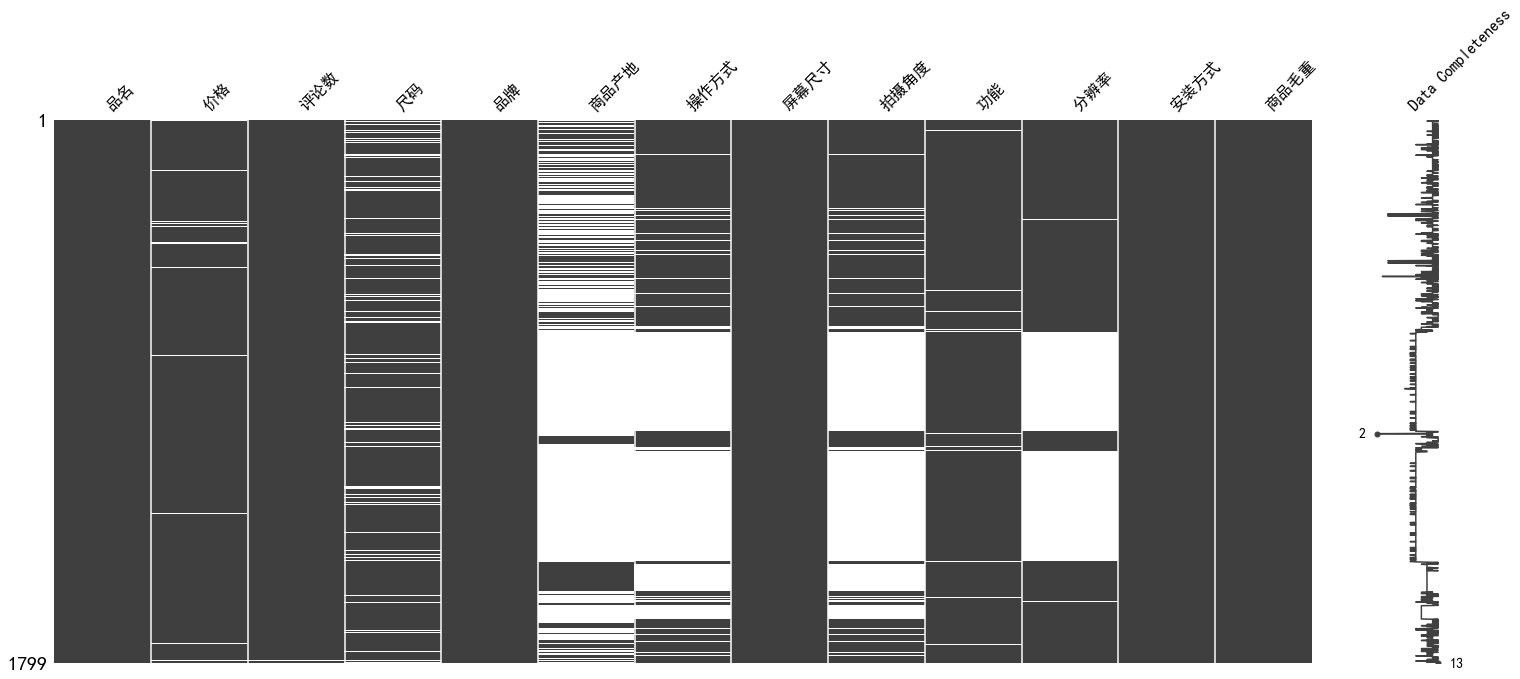

In [5]:
# 缺失值可视化
import missingno as msno
msno.matrix(record, labels = True)

<AxesSubplot:>

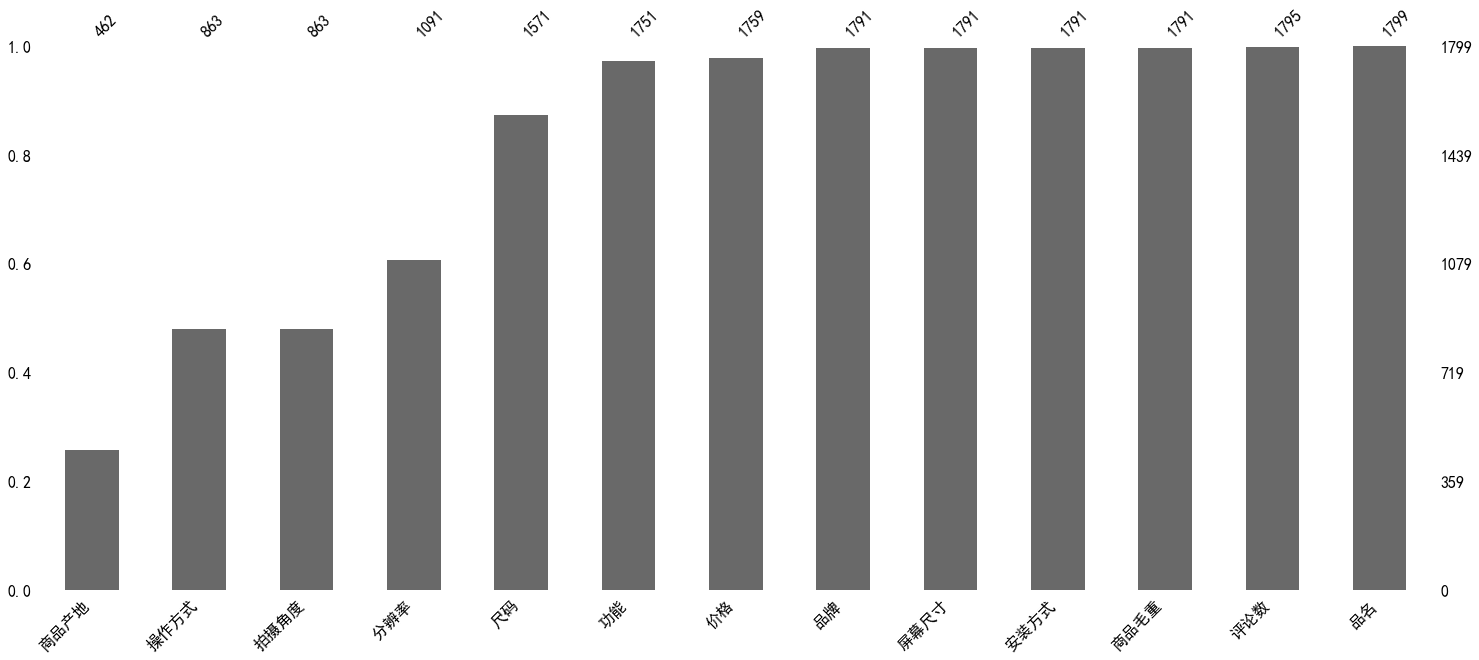

In [6]:
msno.bar(record, sort = 'ascending')

<AxesSubplot:>

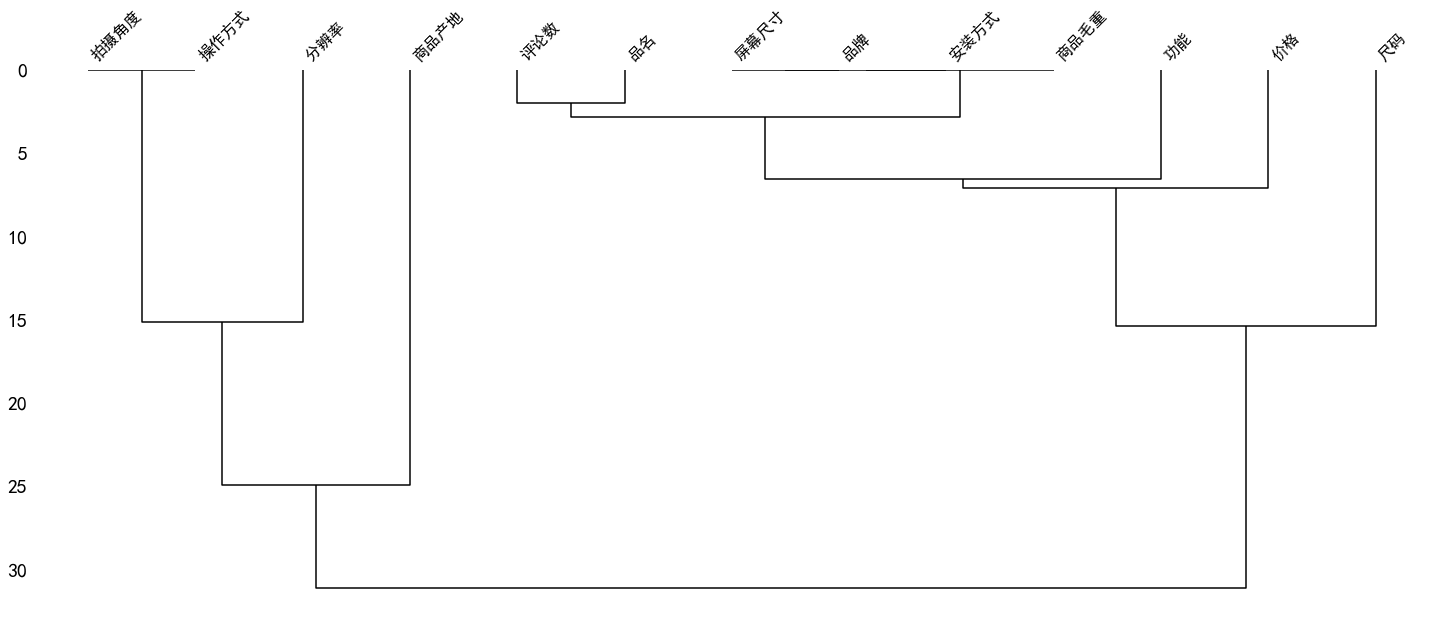

In [7]:
msno.dendrogram(record)

### 数据可视分析

In [8]:
# 价格是不能为空的，如果价格为空则去掉
record = record.dropna(axis = 0,subset = ['价格'])
# 将品牌为空的条目去掉
record = record.dropna(axis = 0,subset = ['品牌'])


# 缺失值处理
record['操作方式'].fillna('未知', inplace = True)
record['分辨率'].fillna('未知', inplace = True)
record['拍摄角度'].fillna('未知', inplace = True)
record['安装方式'].fillna('未知', inplace = True)
record['商品产地'].fillna('未知', inplace = True)
# lost_price_brand = ''
# record['价格'].fillna(record[record['品牌'] == lost_price_brand]['价格'].mean())
# record['功能'].fillna('', inplace = True)
# 商品产地为空的超过了2/3，并且非空的大部分是“中国大陆”，所以去掉
for index,row in record.iterrows():
    if row['屏幕尺寸'] == '无屏幕':
        record.loc[index,'屏幕尺寸'] = 0.0
    else:
        record.loc[index,'屏幕尺寸'] = float(row['屏幕尺寸'].split("英寸")[0])
    record.loc[index,'商品毛重'] = float(row['商品毛重'].split("g")[0])
record['商品毛重'] = record['商品毛重'].astype('float')

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


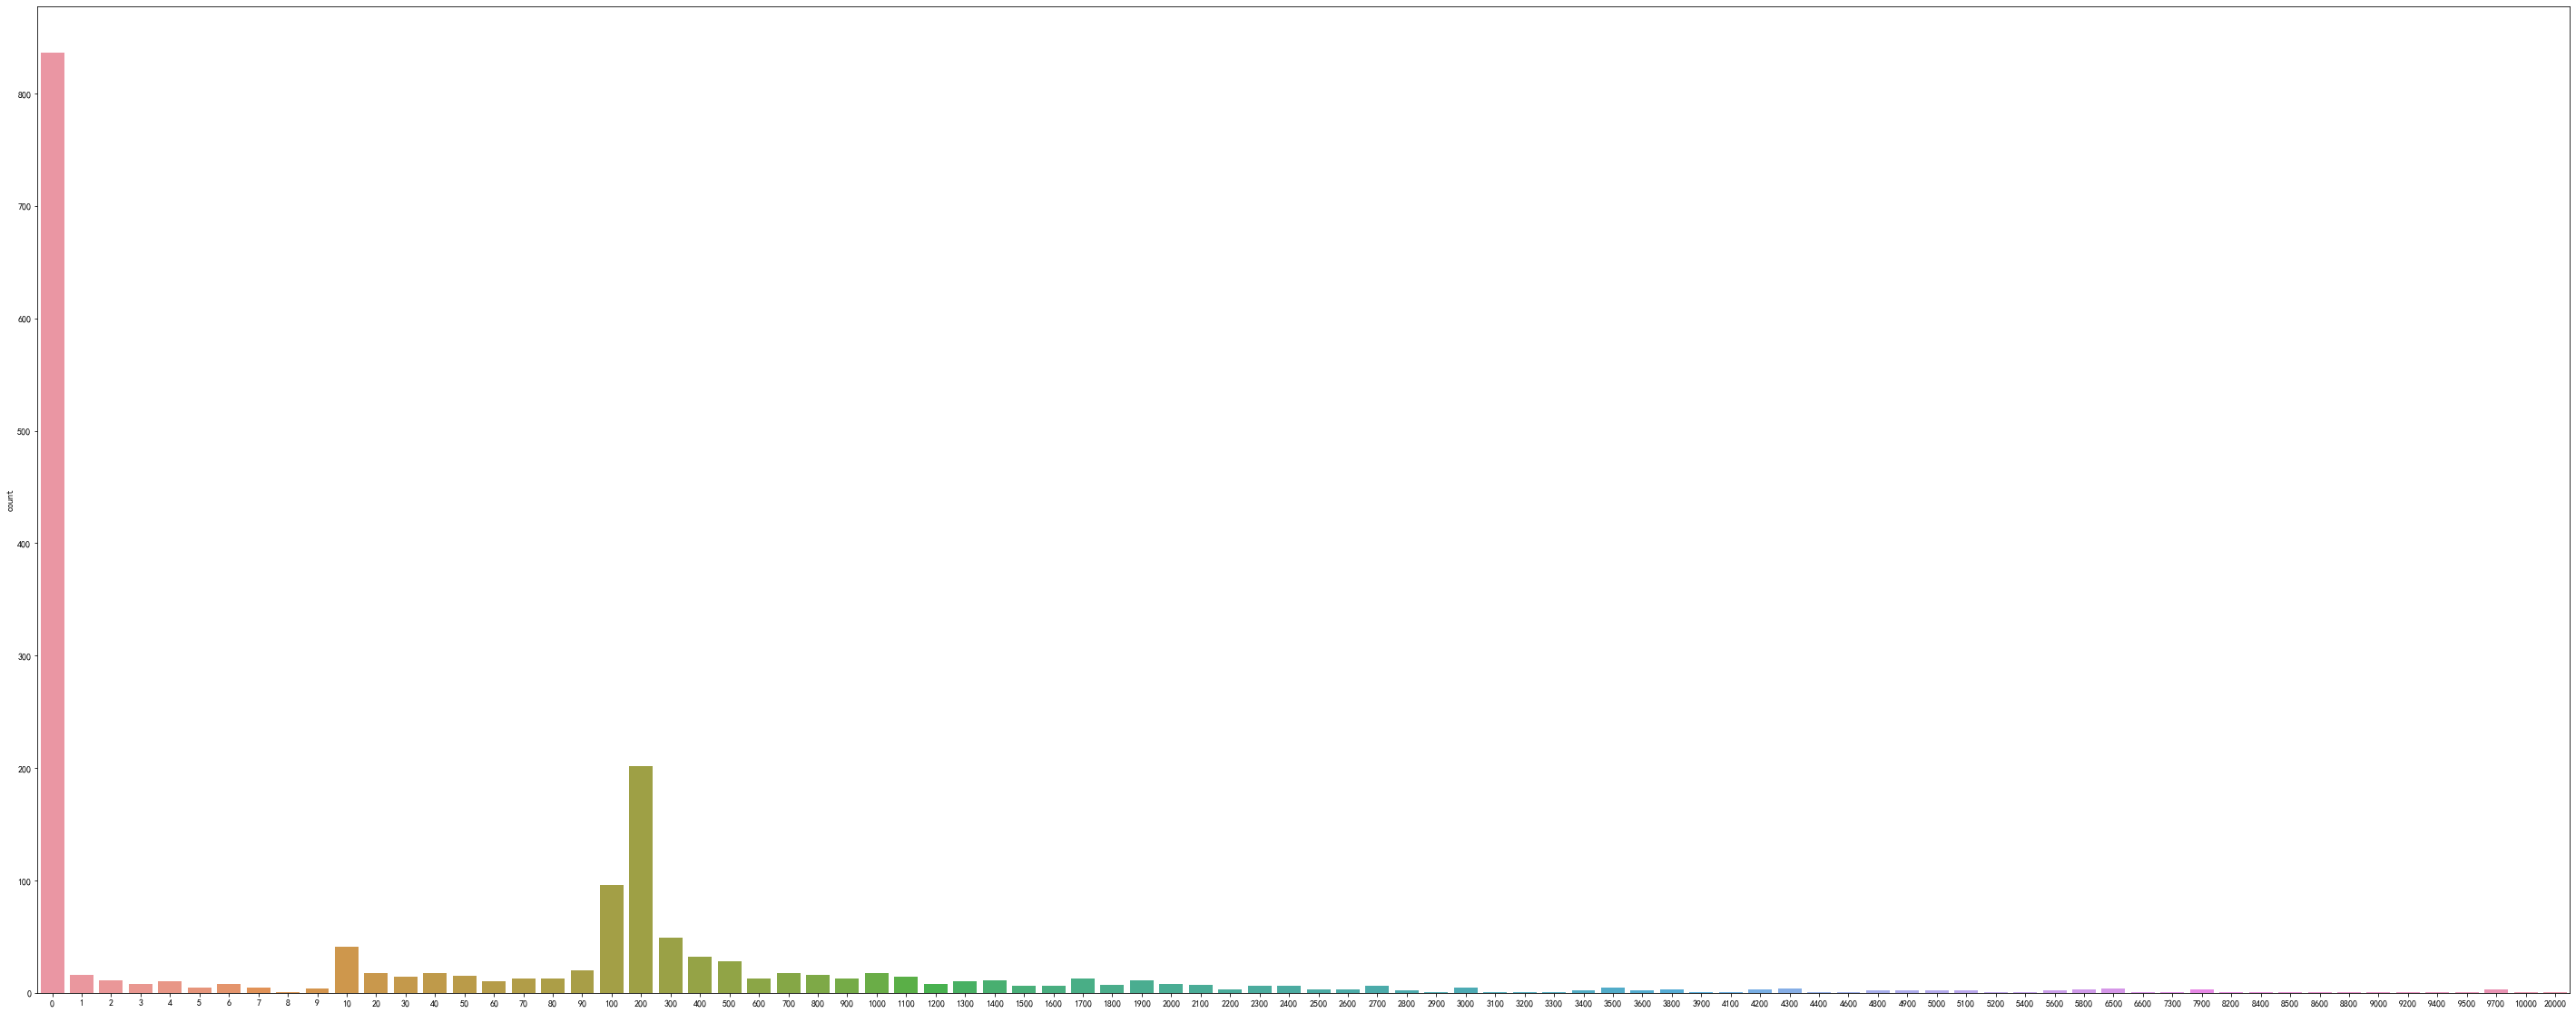

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


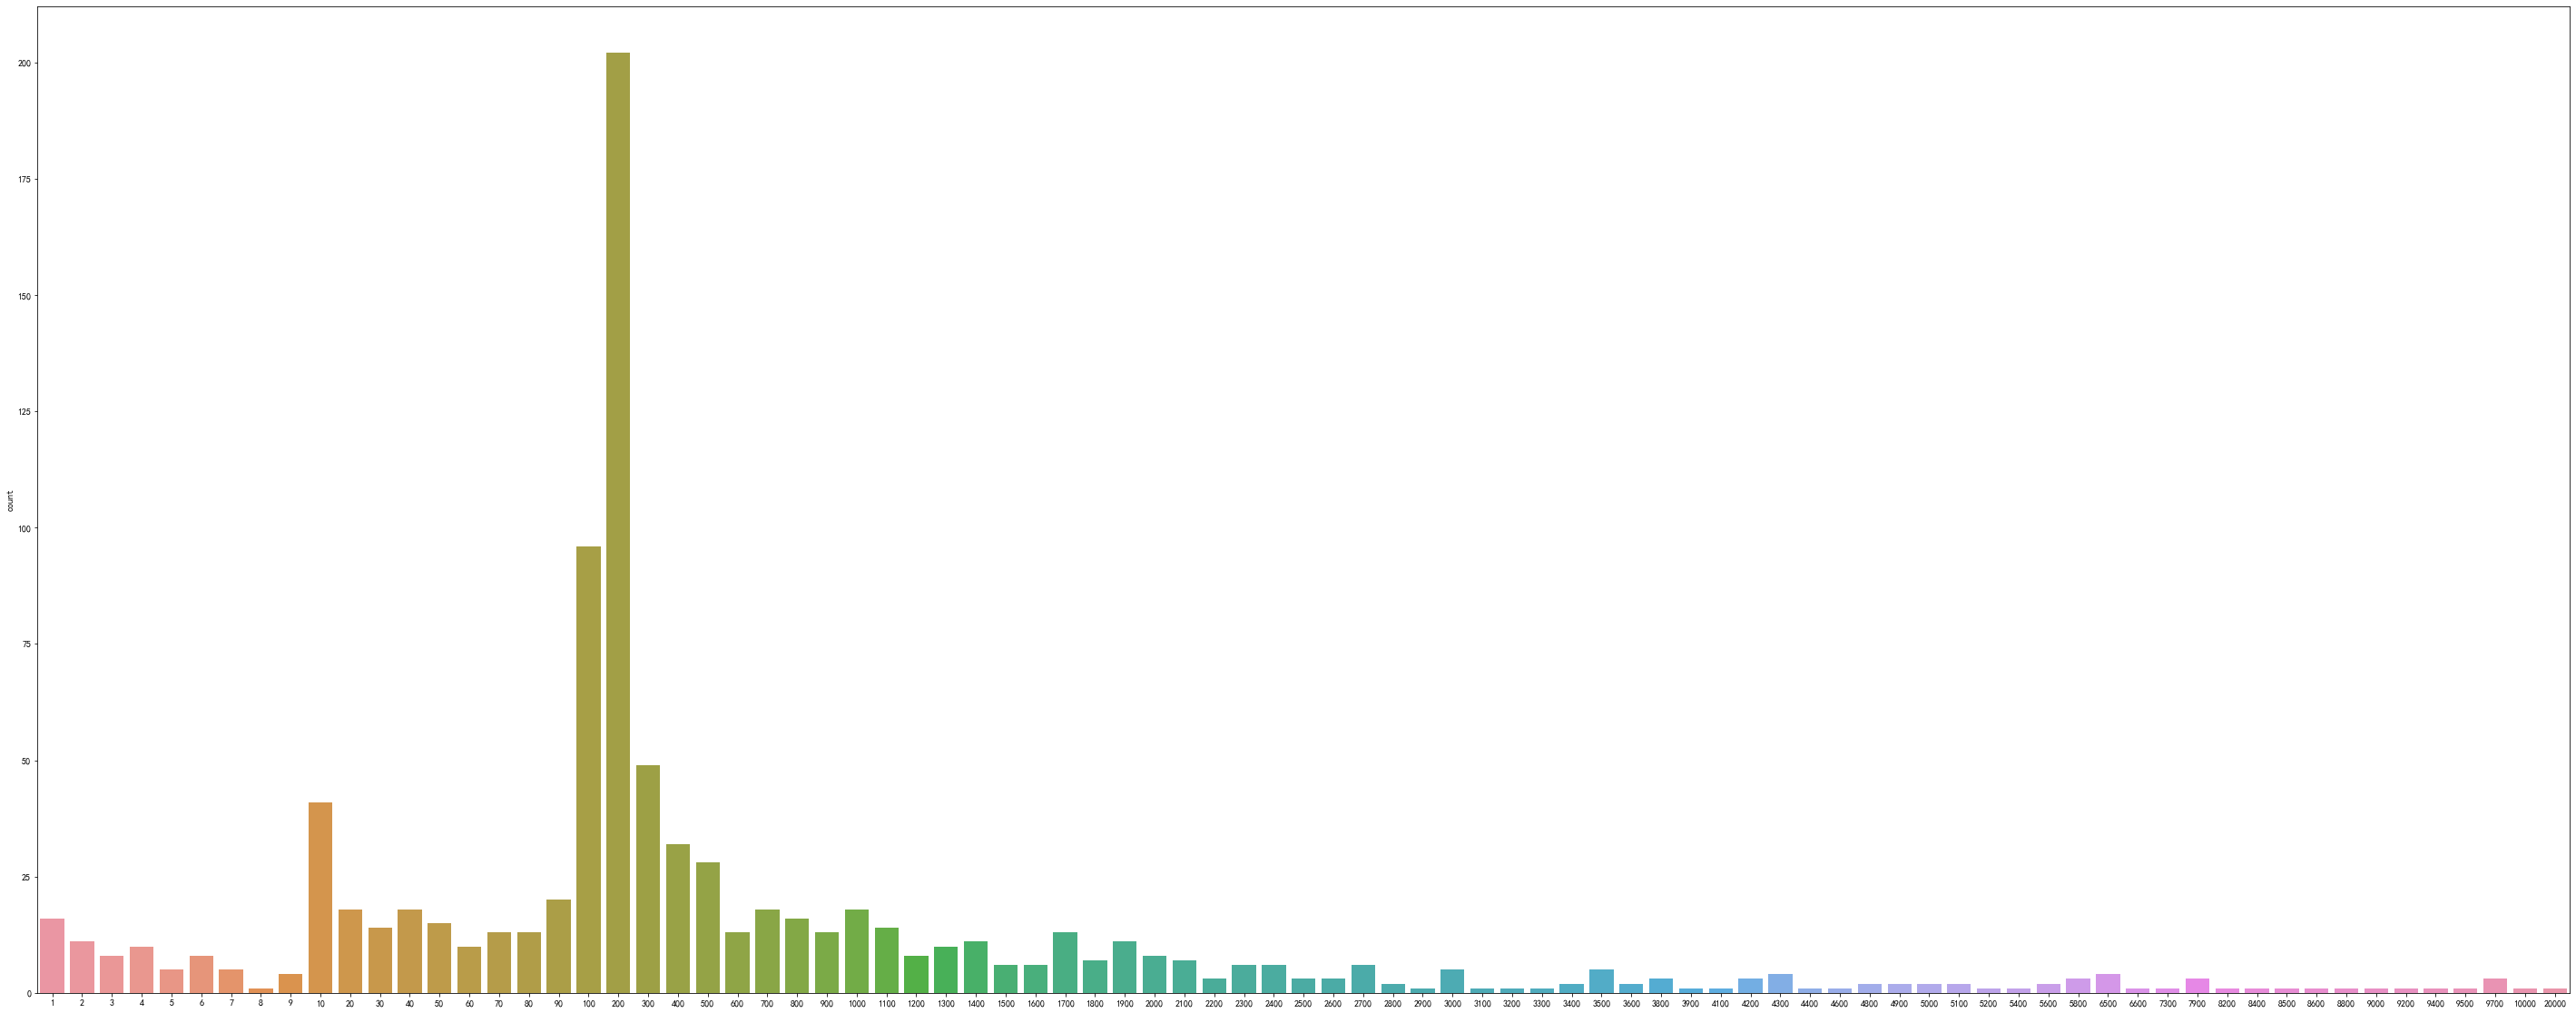

[  60.  200.  300. 1200.]


In [9]:
# 销量（评论数）
# 删去空数据
record = record.dropna(axis = 0,subset = ['评论数'])
sale = record['评论数'].tolist()
sale = [int(s.split('+')[0]) for s in sale]
plt.figure(figsize=(50,20))
sns.countplot(sale)
# sns.displot(sale, kde=True, height = 5)
plt.show()
# 发现0占了很大部分，所以去掉0
plt.figure(figsize=(50,20))
sns.countplot(list(filter(lambda x: x != 0, sale)))
plt.show()
# sns.kdeplot(sale, shade=True)
# sns.distplot(sale)
# 五分点
bins = np.percentile(list(filter(lambda x: x != 0, sale)), [20, 40, 60, 80]) 
print(bins)

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


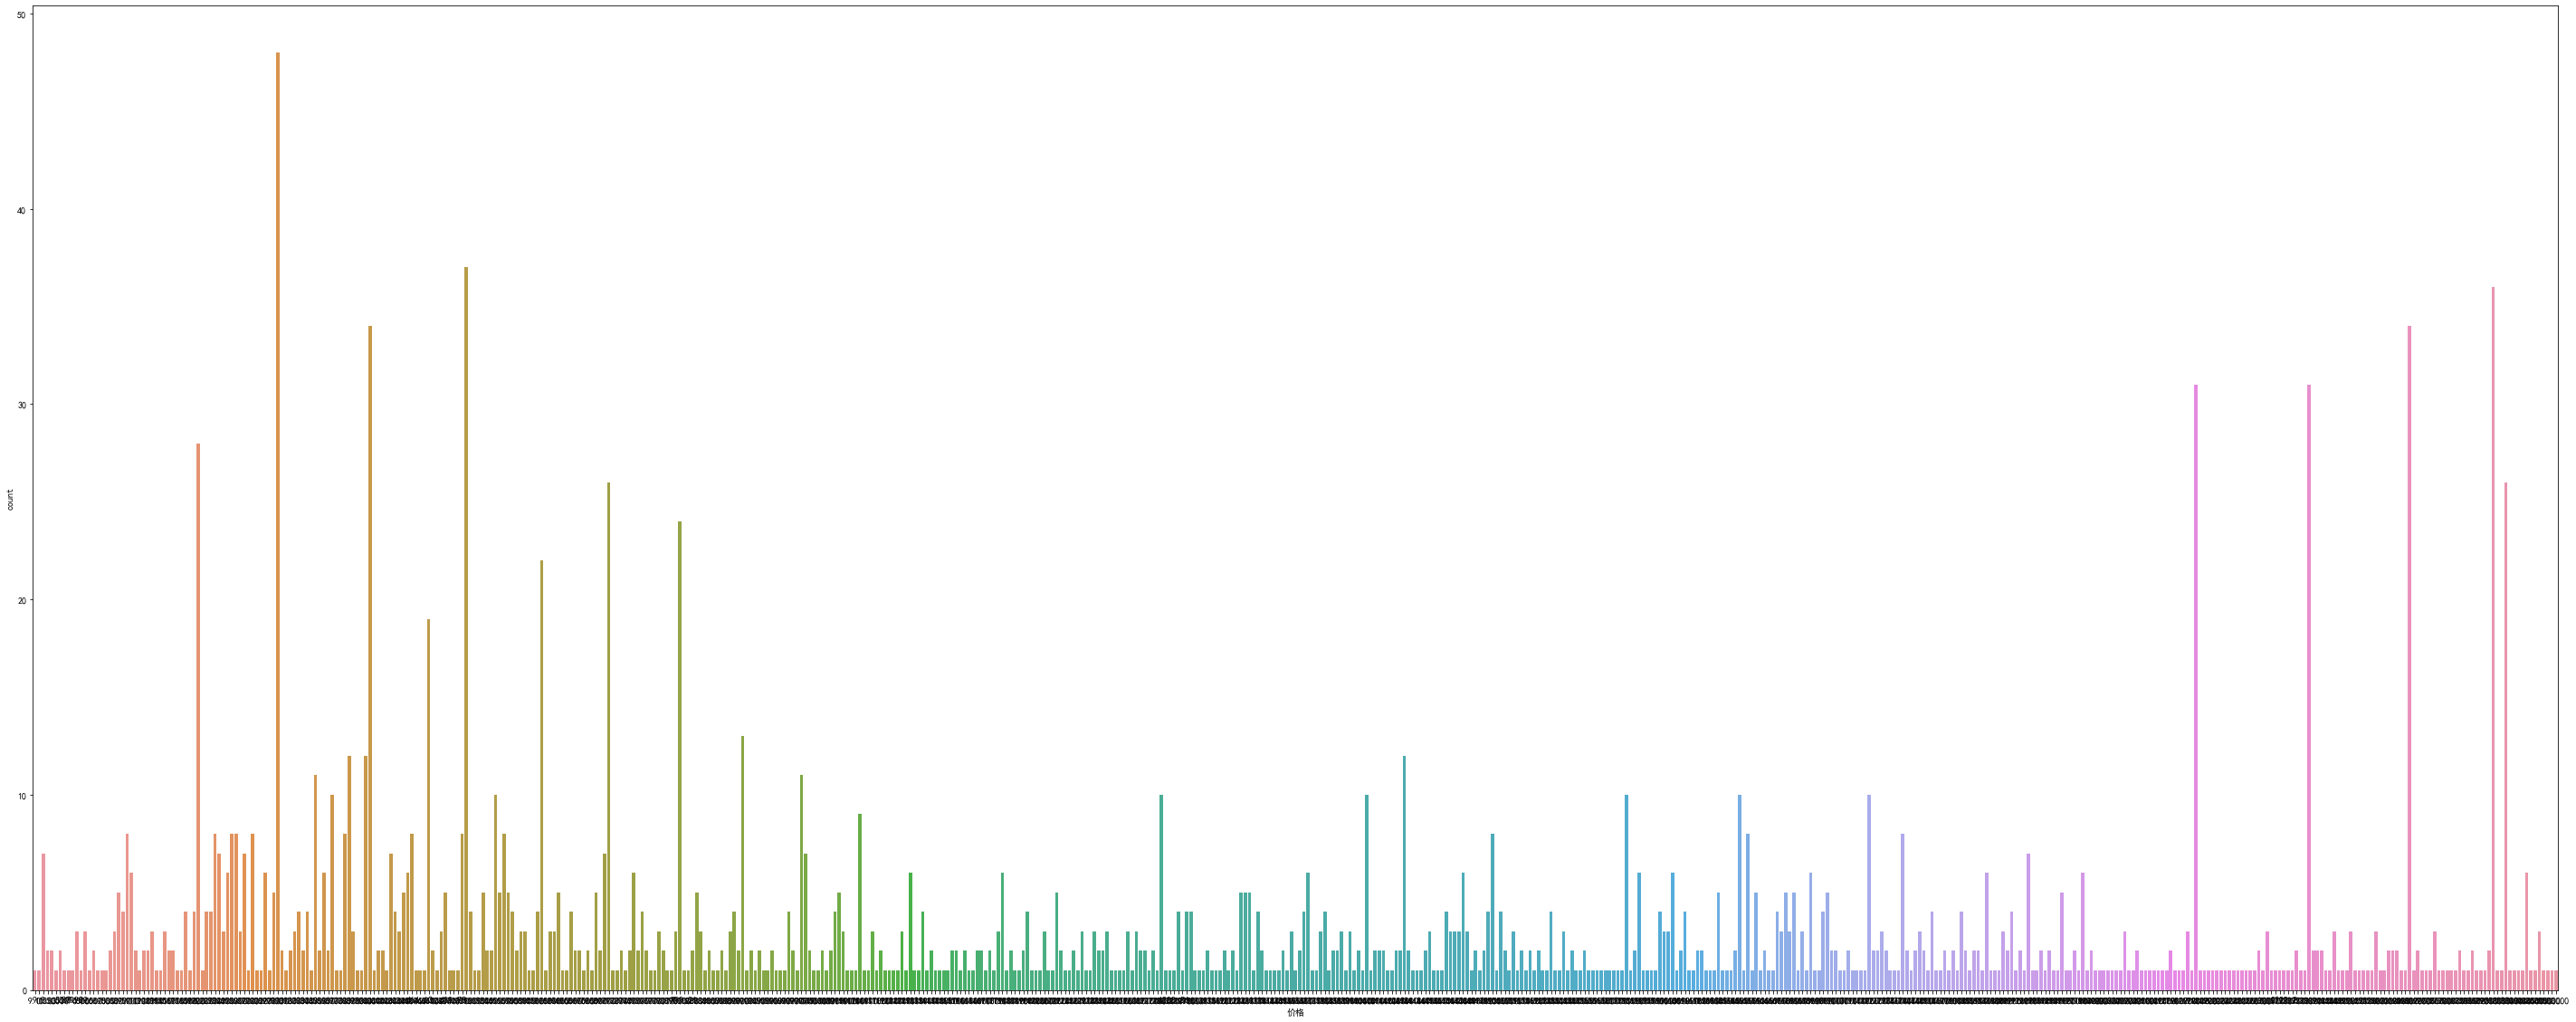

set()


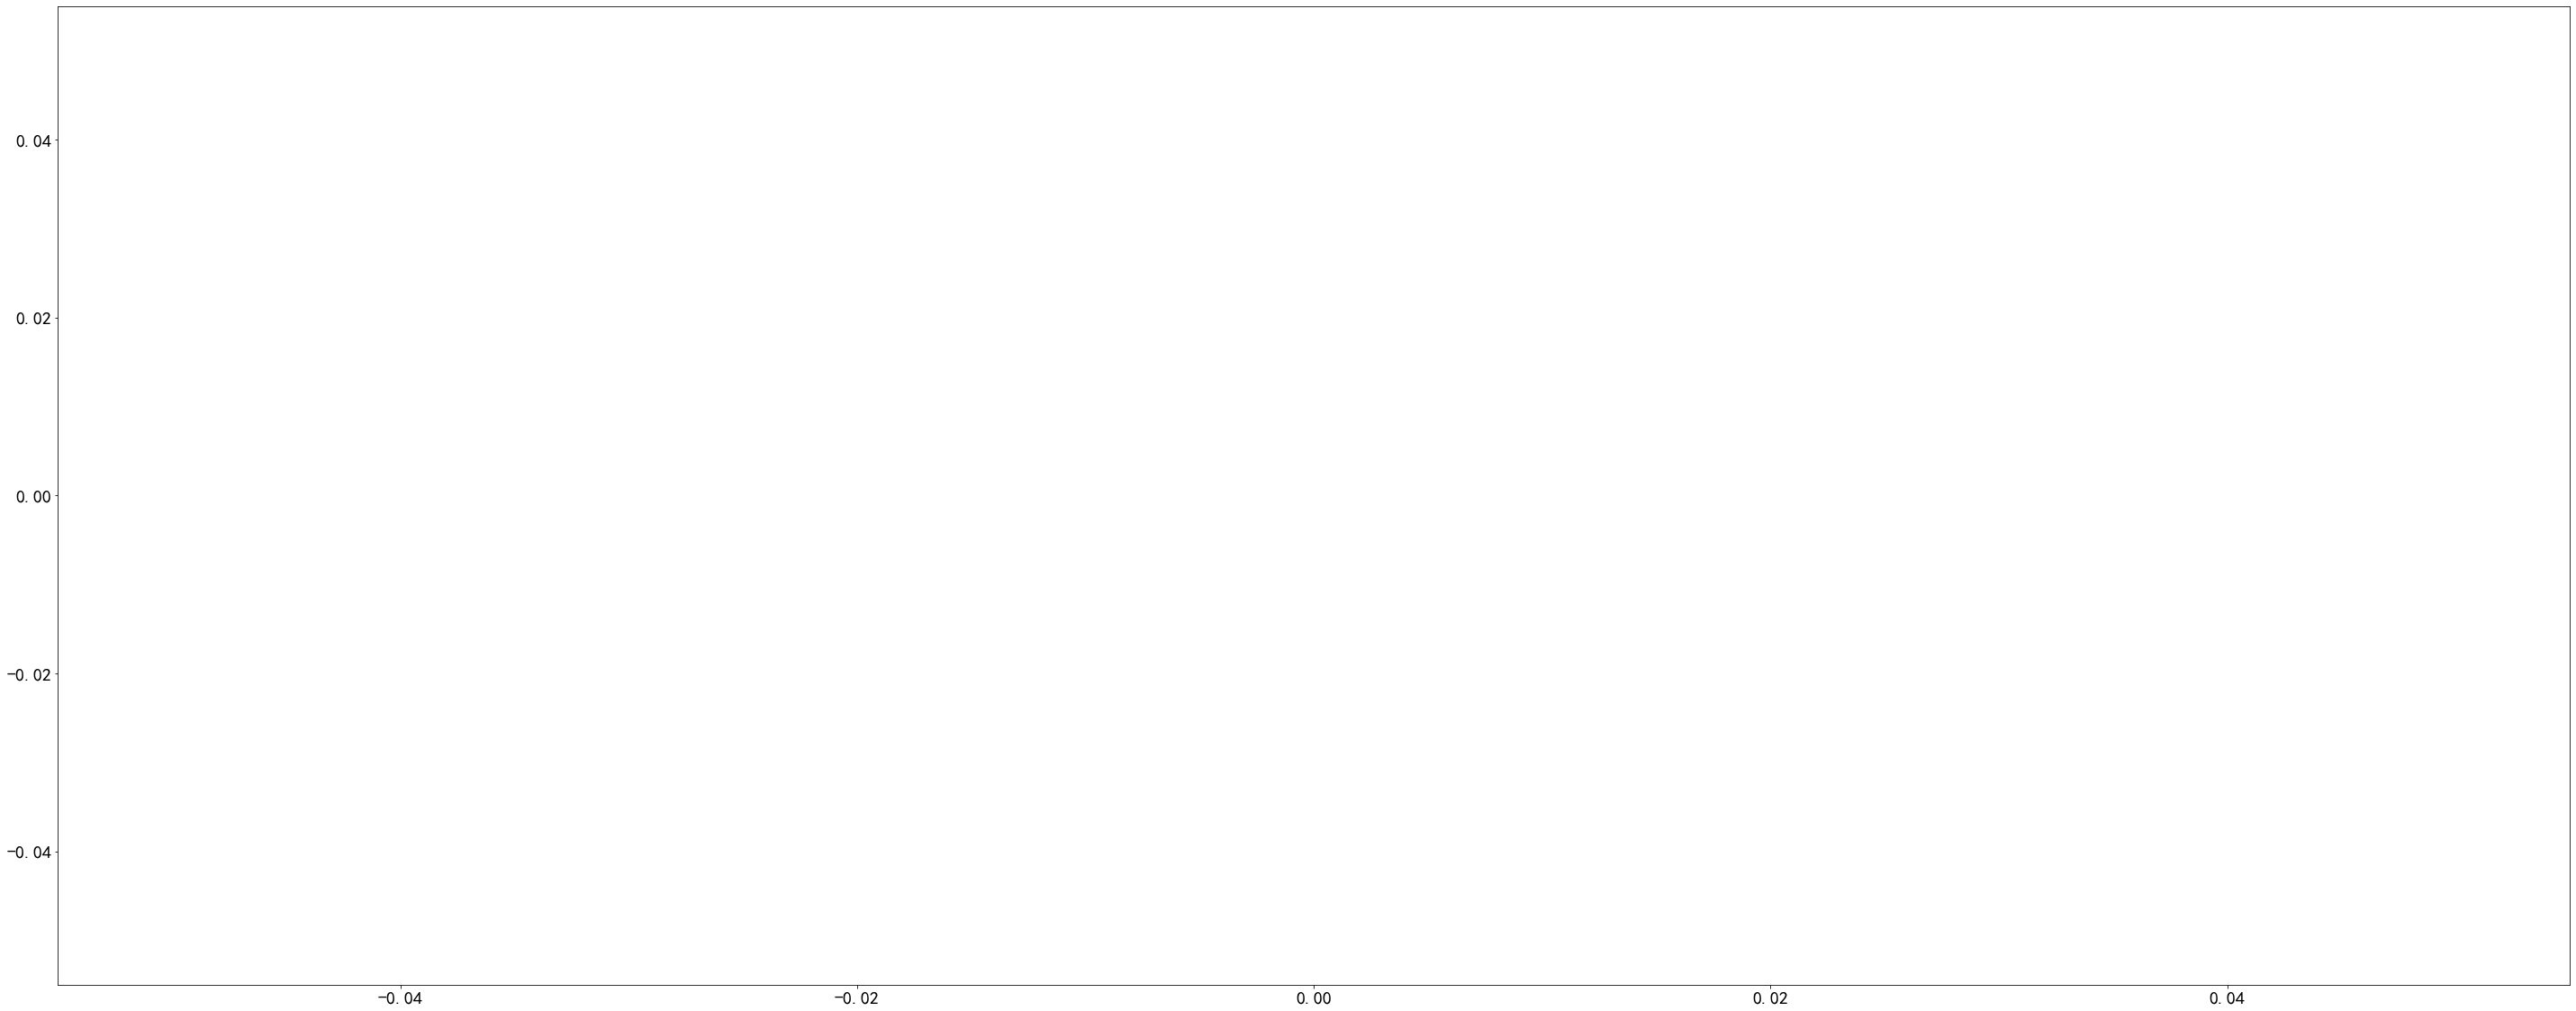

[]


In [10]:
# 价格
# 总体分布
plt.figure(figsize=(50,20))
sns.countplot(record['价格'])
# sns.kdeplot(record['价格'], shade=True)
plt.show()
# 找到为空的数据的品牌
brand_nan = set()
for index,row in record.iterrows():
    # print(pd.isna(row['价格']))
    if pd.isna(row['价格']):
        brand_nan.add(row['品牌'])
print(brand_nan)
# 每个品牌的价格方差
brand_names = list(brand_nan)
price_variance = []
for name in brand_names:
    price_list = []
    for index,row in record.iterrows():
        if pd.isna(row['价格']) == False and row['品牌'] == name:
            brand_nan.add(row['品牌'])
            price_list.append(row['价格'])
    variance = np.var(price_list)
    price_variance.append(variance)
plt.figure(figsize=(50,20))
plt.rcParams['font.size']=20    
plt.bar(brand_names,price_variance)
plt.show()
print(price_variance)
# 因为方差都比较大，所以选择去掉价格为空的数据
# record = record.dropna(axis = 0,subset = ['价格'])

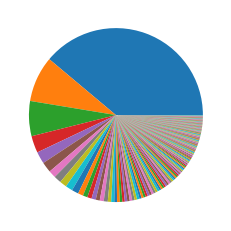

<Figure size 3600x3600 with 0 Axes>

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


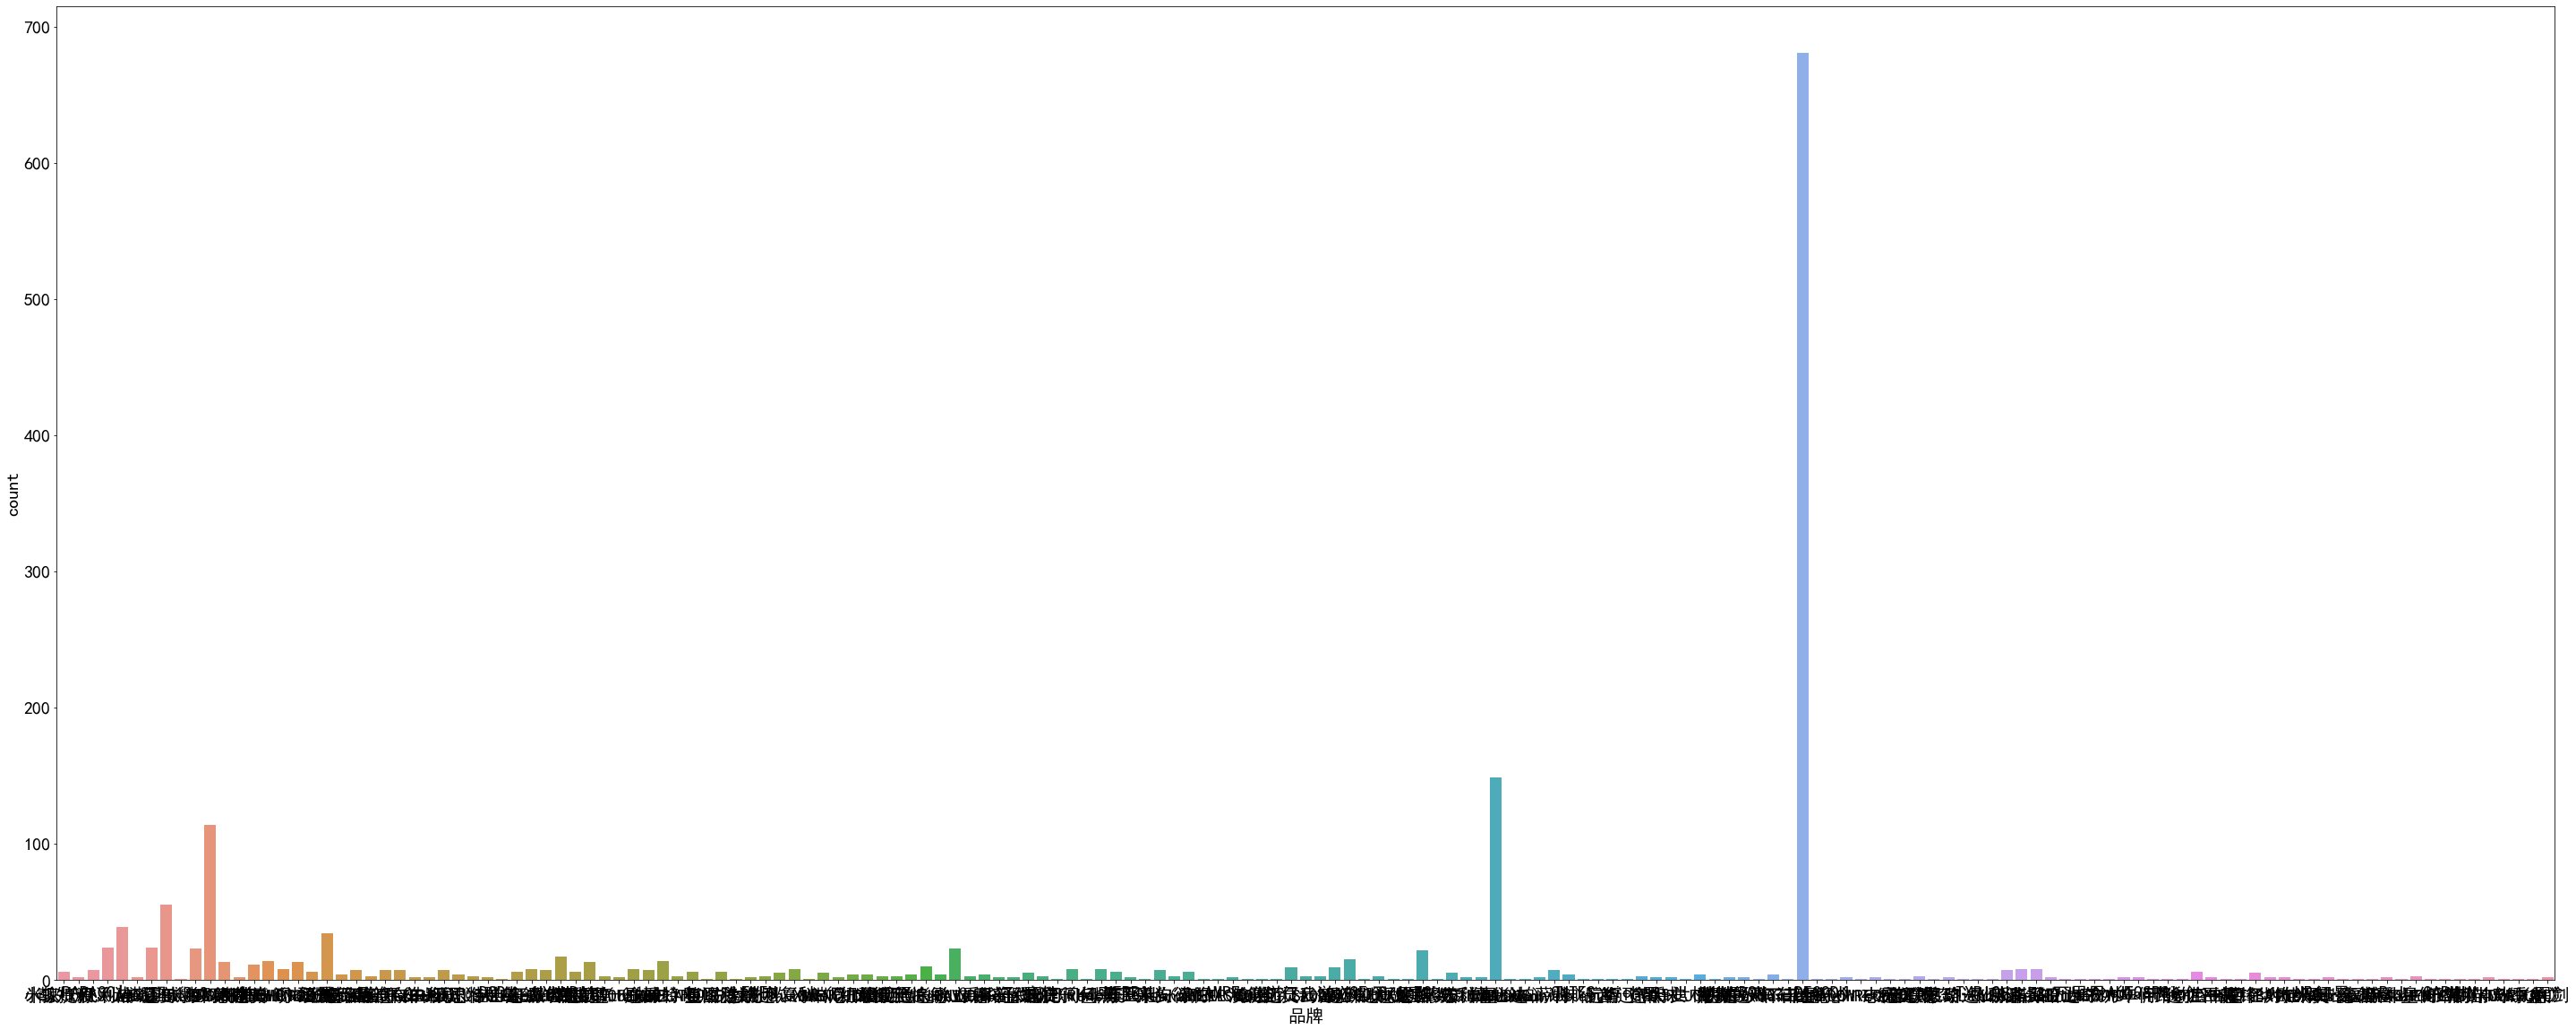

 吉士野                    681
 卡仕达                    149
 凌度（BLACKVIEW）          114
 丁威特                     55
 靓知渝（liangzhiyu）         39
                       ... 
 统畅                       1
 车享                       1
 优驾                       1
 联想（Lenovo）               1
 影天下（SHADOWRECORDER）      1
Name: 品牌, Length: 171, dtype: int64


In [11]:
# 品牌
# 饼图
plt.pie(record['品牌'].value_counts())
plt.figure(figsize=(50,50))
plt.show()
# 将品牌为空的条目去掉
record = record.dropna(axis = 0,subset = ['品牌'])
plt.figure(figsize=(50,20))
sns.countplot(record['品牌'])
plt.show()
print(record['品牌'].value_counts())

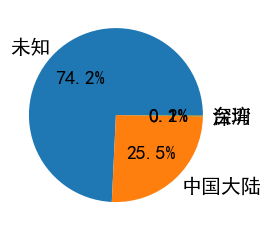

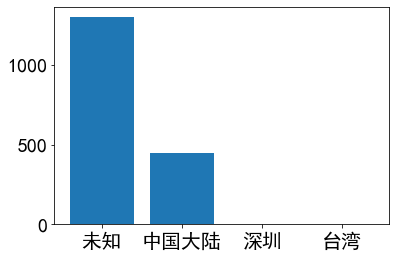

In [12]:
# 商品产地
# 饼图
record['商品产地'].fillna('未知', inplace = True)
# plt.figure(figsize=(20,20)) 
plt.pie(record['商品产地'].value_counts(),autopct='%1.1f%%',labels=['未知','中国大陆','深圳','台湾'])
plt.show()
# plt.rcParams['font.size']=20    
plt.bar(['未知','中国大陆','深圳','台湾'],record['商品产地'].value_counts())
plt.show()

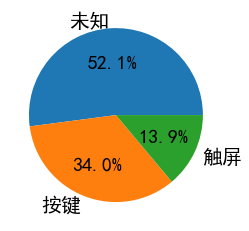

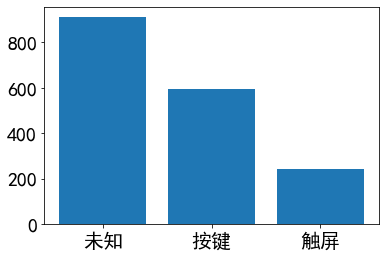

In [13]:
# 操作方式
# 饼图
record['操作方式'].fillna('未知', inplace = True)
plt.pie(record['操作方式'].value_counts(),autopct='%1.1f%%',labels=['未知','按键','触屏'])
plt.show()   
plt.bar(['未知','按键','触屏'],record['操作方式'].value_counts())
plt.show()

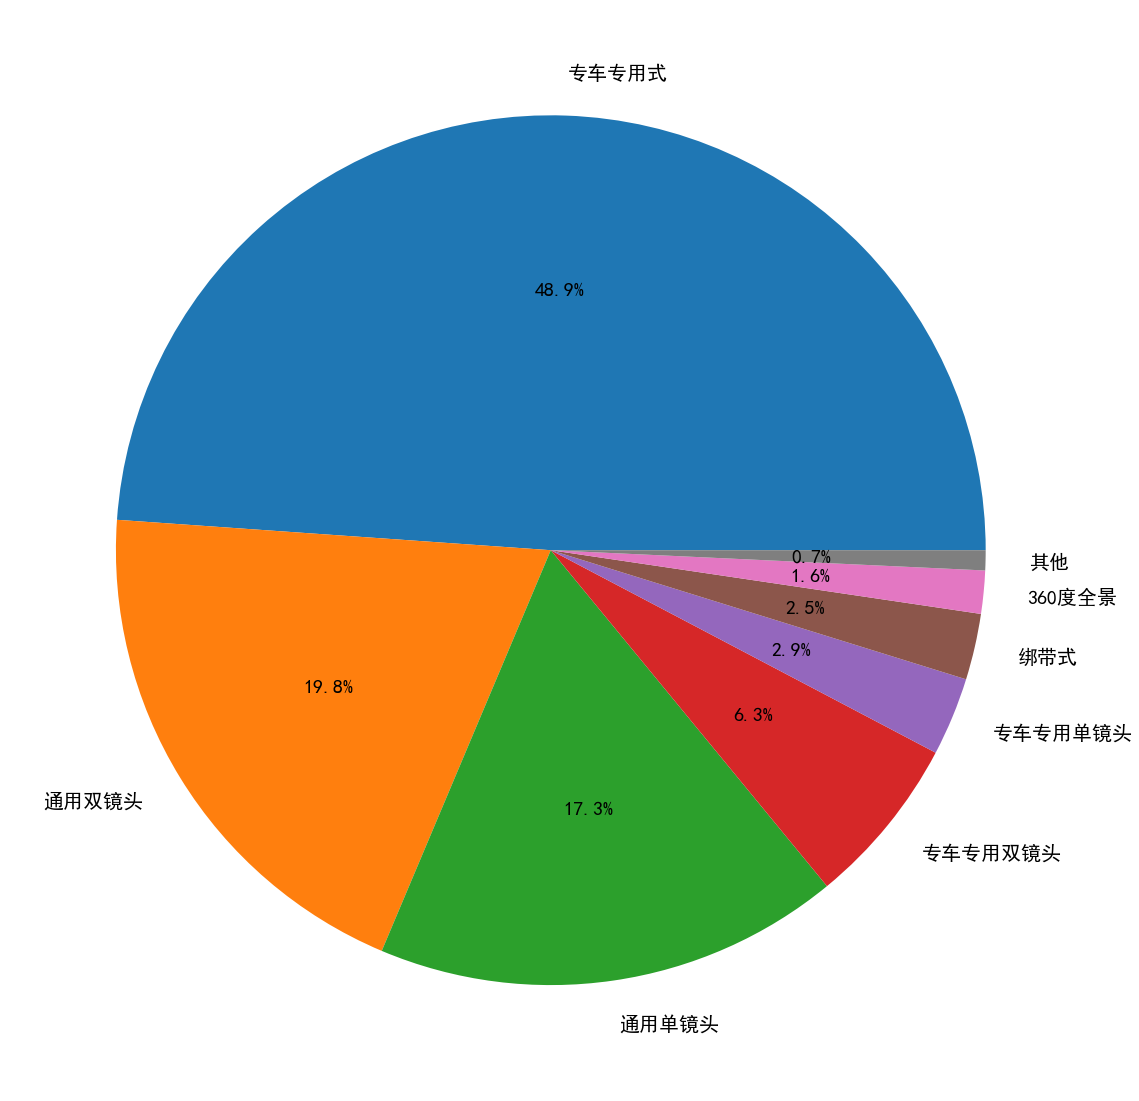

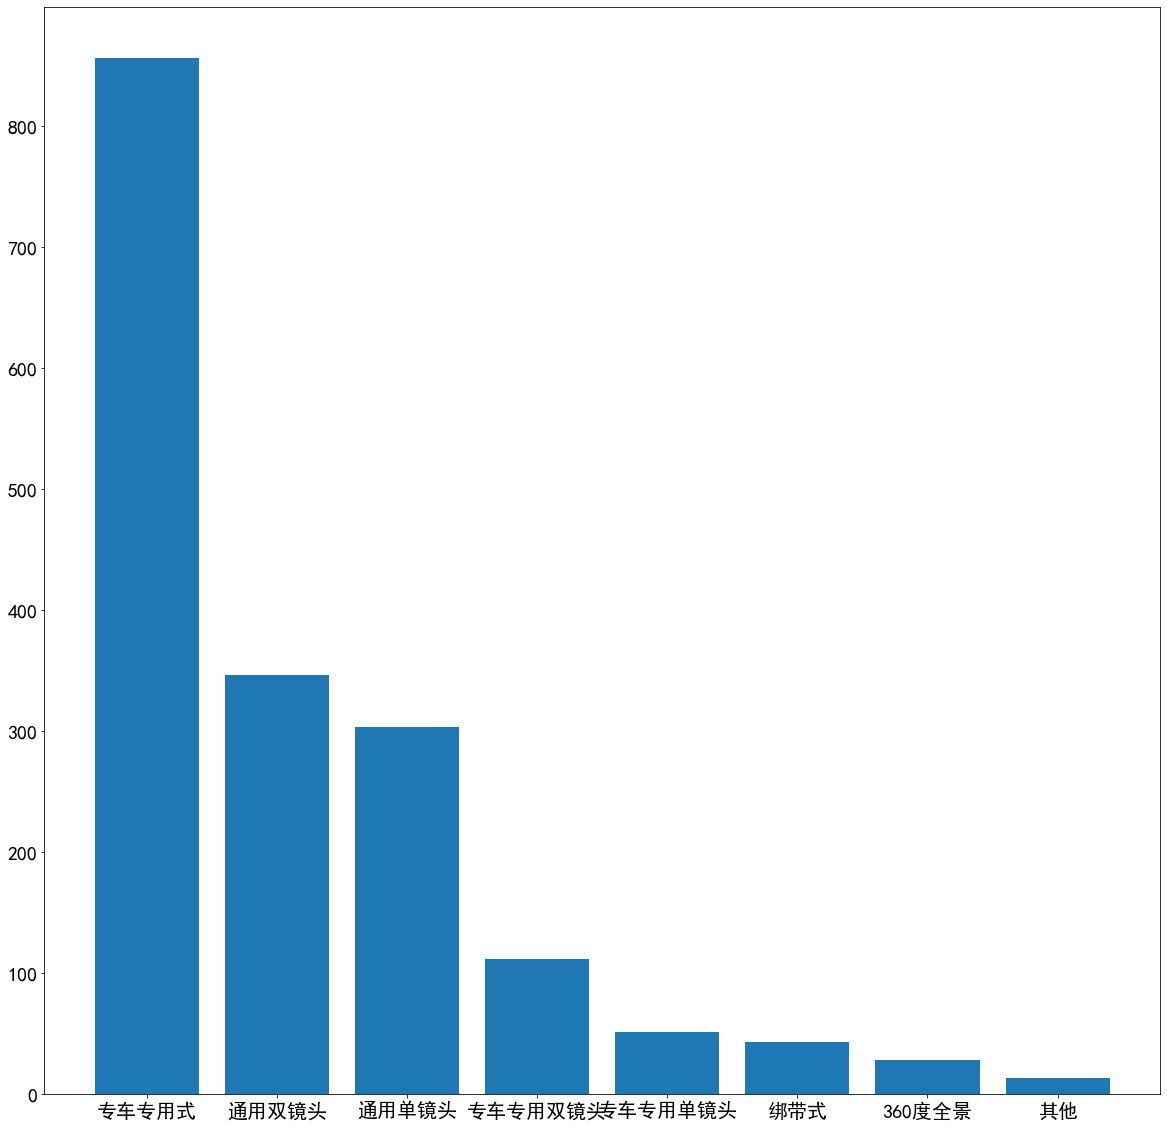

In [14]:
# 安装方式
# 饼图
record['安装方式'].fillna('未知', inplace = True)
plt.figure(figsize=(20,20))  
plt.pie(record['安装方式'].value_counts(),autopct='%1.1f%%',labels=record['安装方式'].value_counts().keys())
plt.show()
plt.figure(figsize=(20,20))  
plt.bar(record['安装方式'].value_counts().keys(),record['安装方式'].value_counts())
plt.show()

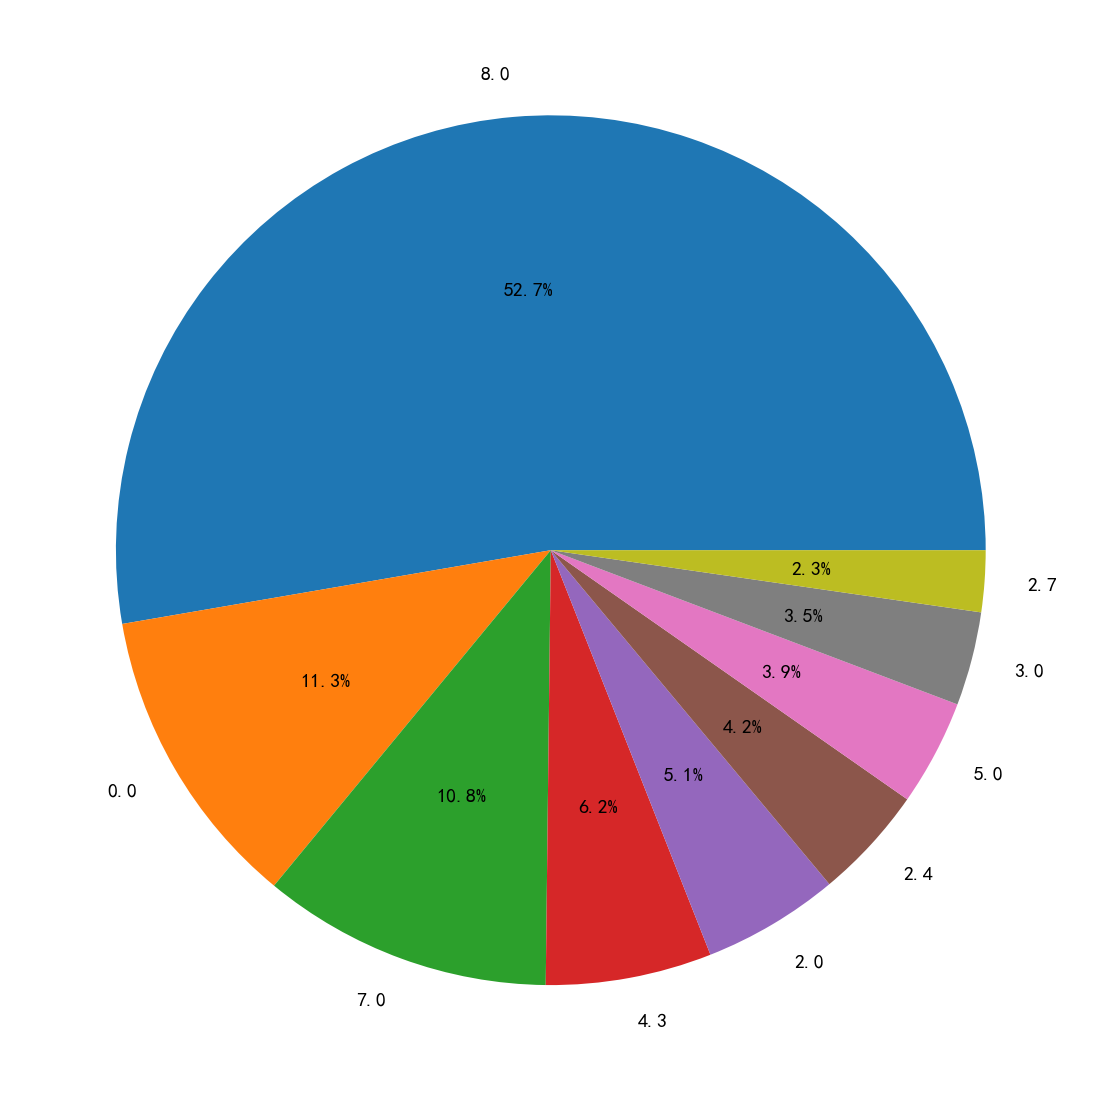

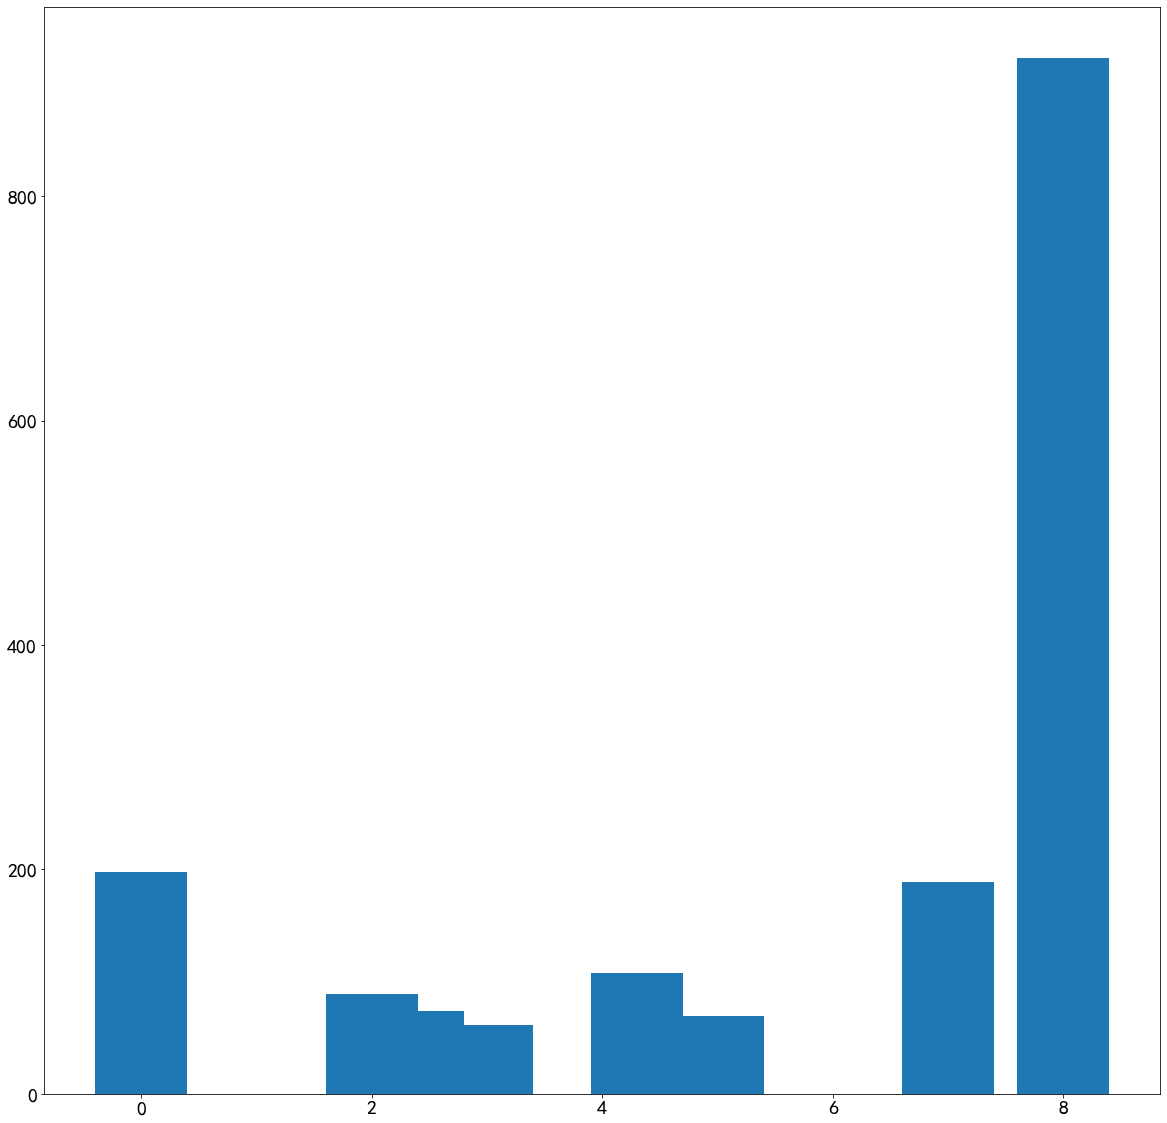

In [15]:
# 屏幕尺寸
# 饼图
record['屏幕尺寸'].fillna('未知', inplace = True)
plt.figure(figsize=(20,20))  
plt.pie(record['屏幕尺寸'].value_counts(),autopct='%1.1f%%',labels=record['屏幕尺寸'].value_counts().keys())
plt.show()
plt.figure(figsize=(20,20))  
plt.bar(record['屏幕尺寸'].value_counts().keys(),record['屏幕尺寸'].value_counts())
plt.show()

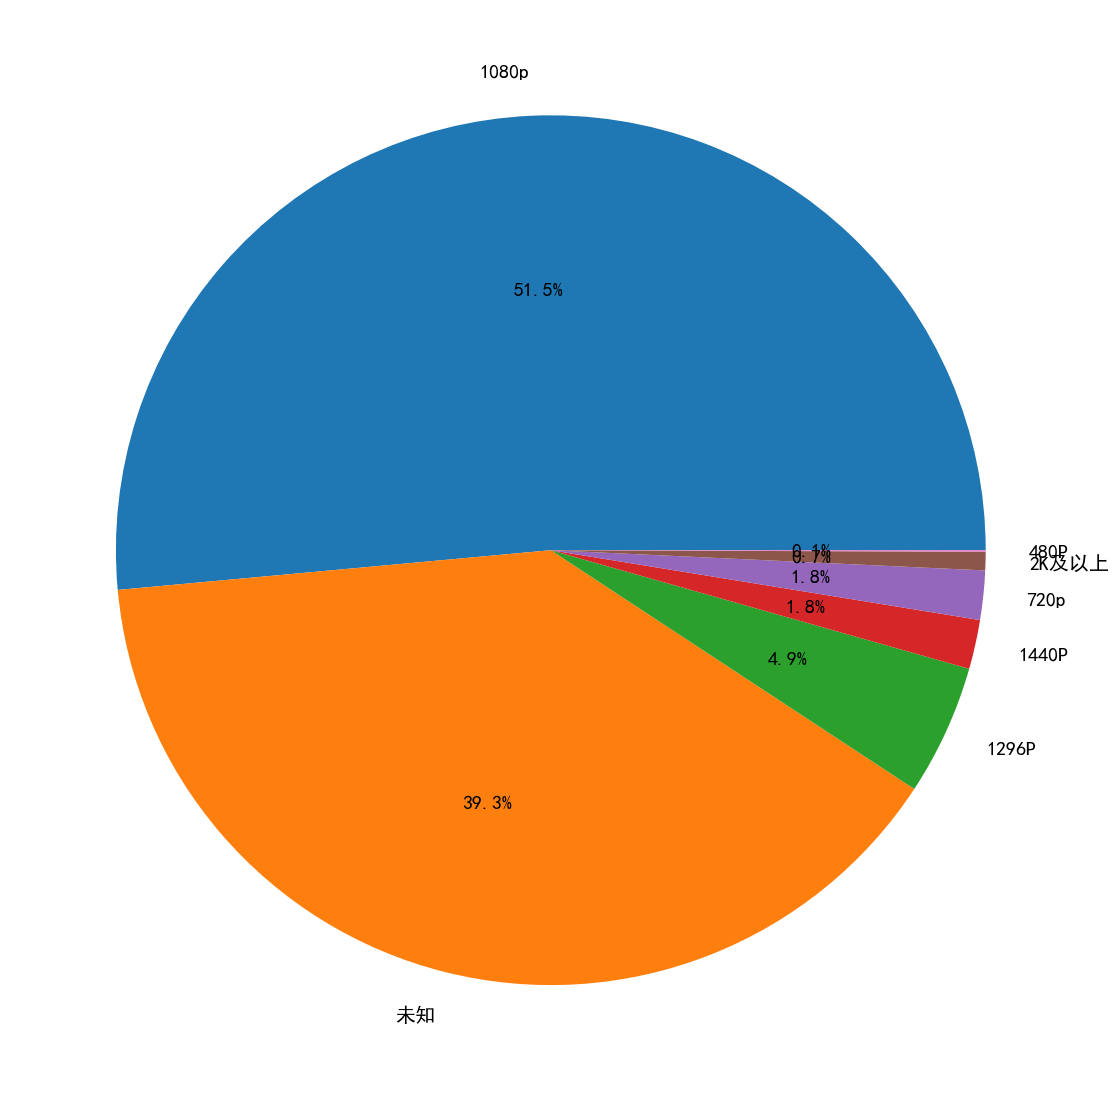

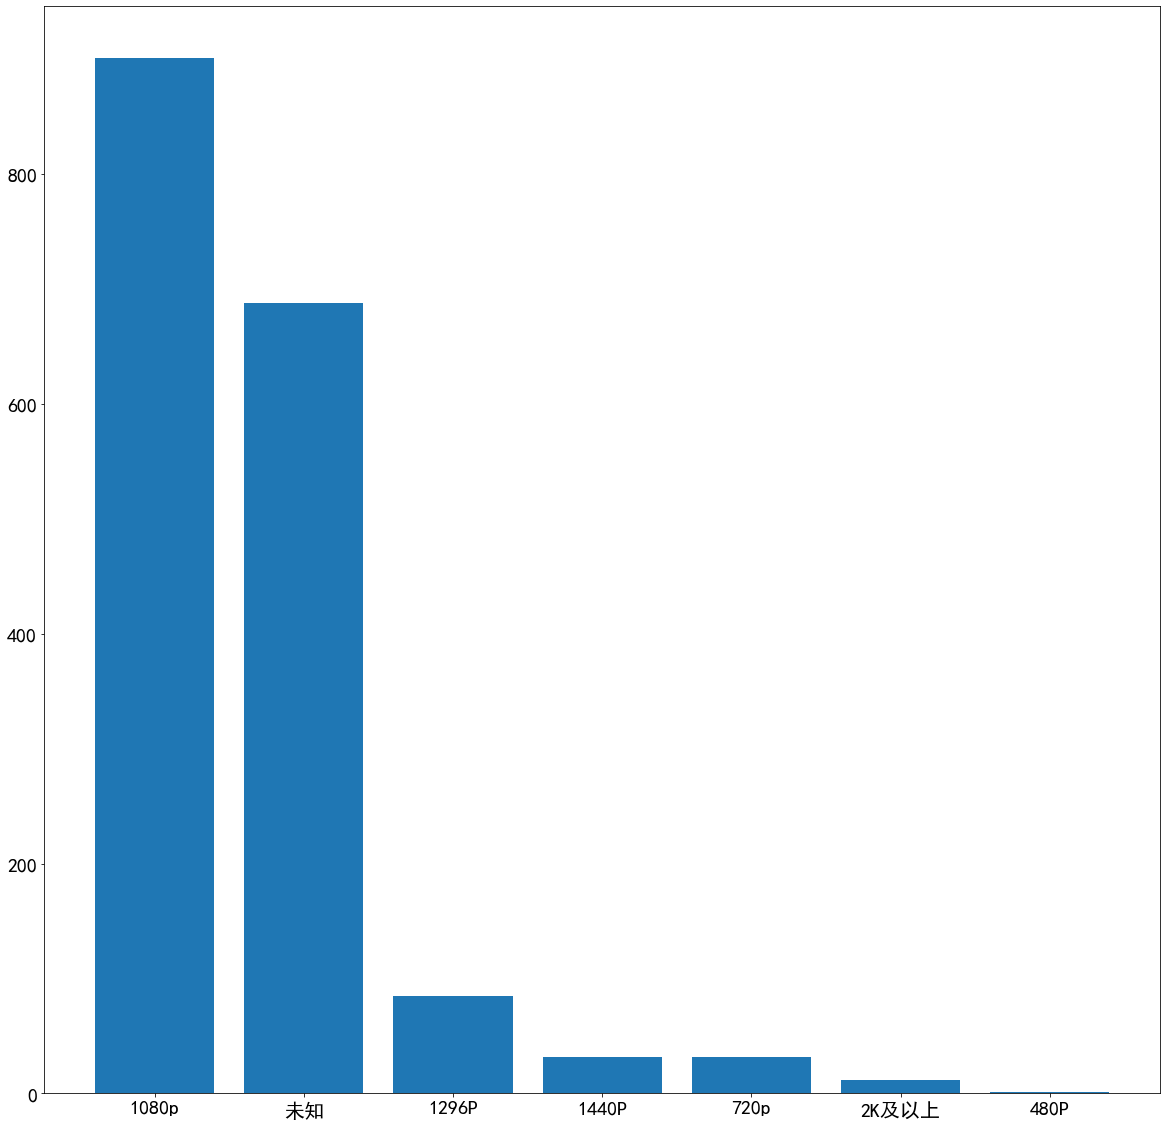

In [16]:
# 分辨率
record['分辨率'].fillna('未知', inplace = True)
plt.figure(figsize=(20,20))  
plt.pie(record['分辨率'].value_counts(),autopct='%1.1f%%',labels=record['分辨率'].value_counts().keys())
plt.show()
plt.figure(figsize=(20,20))  
plt.bar(record['分辨率'].value_counts().keys(),record['分辨率'].value_counts())
plt.show()

<Figure size 3600x1440 with 0 Axes>

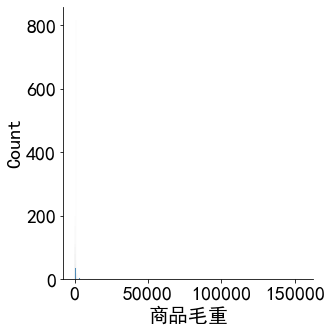

In [17]:
# 商品毛重
plt.figure(figsize=(50,20))
sns.displot(record['商品毛重'])

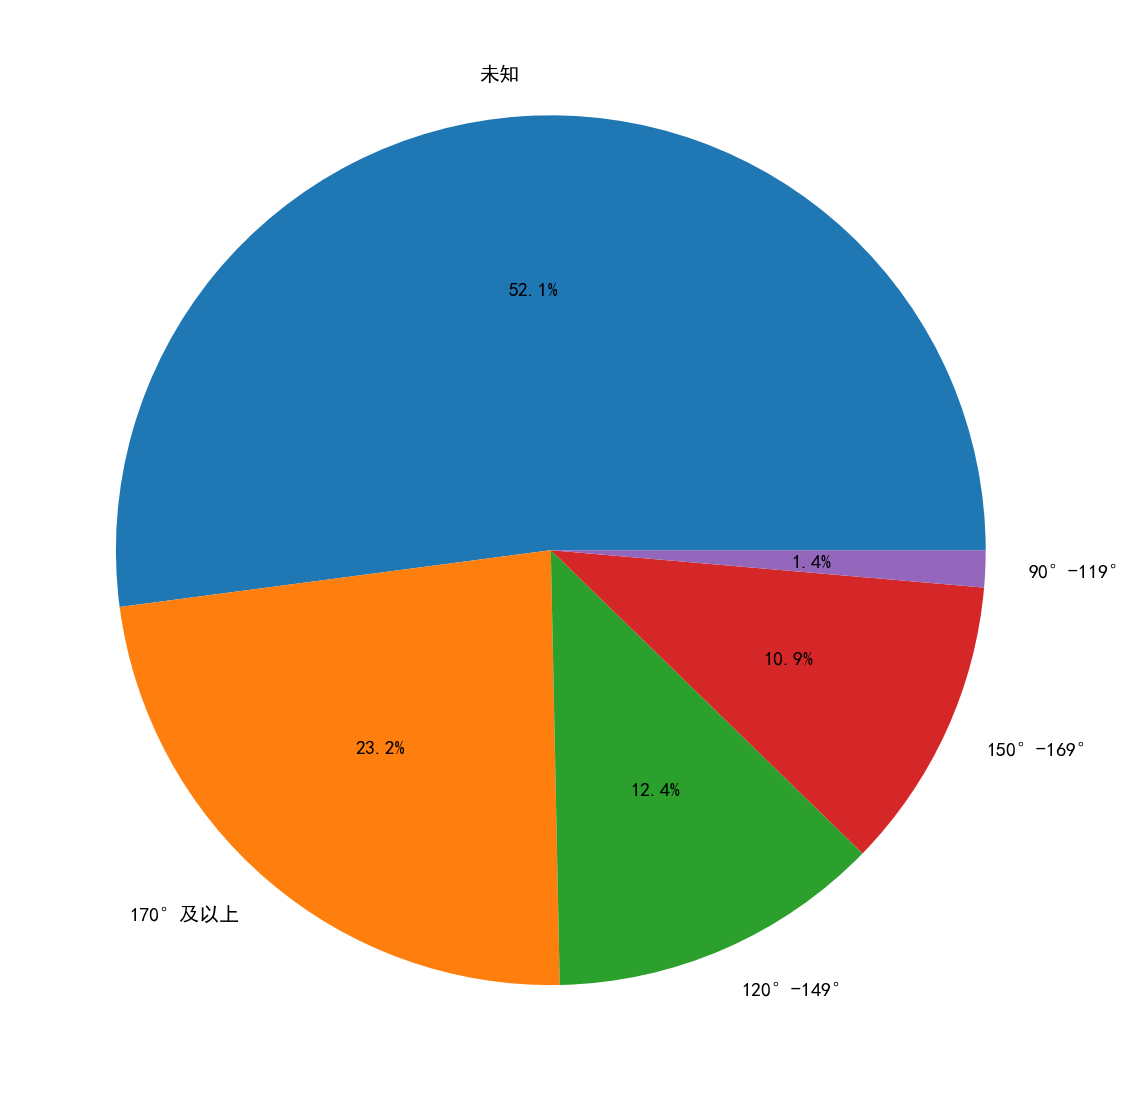

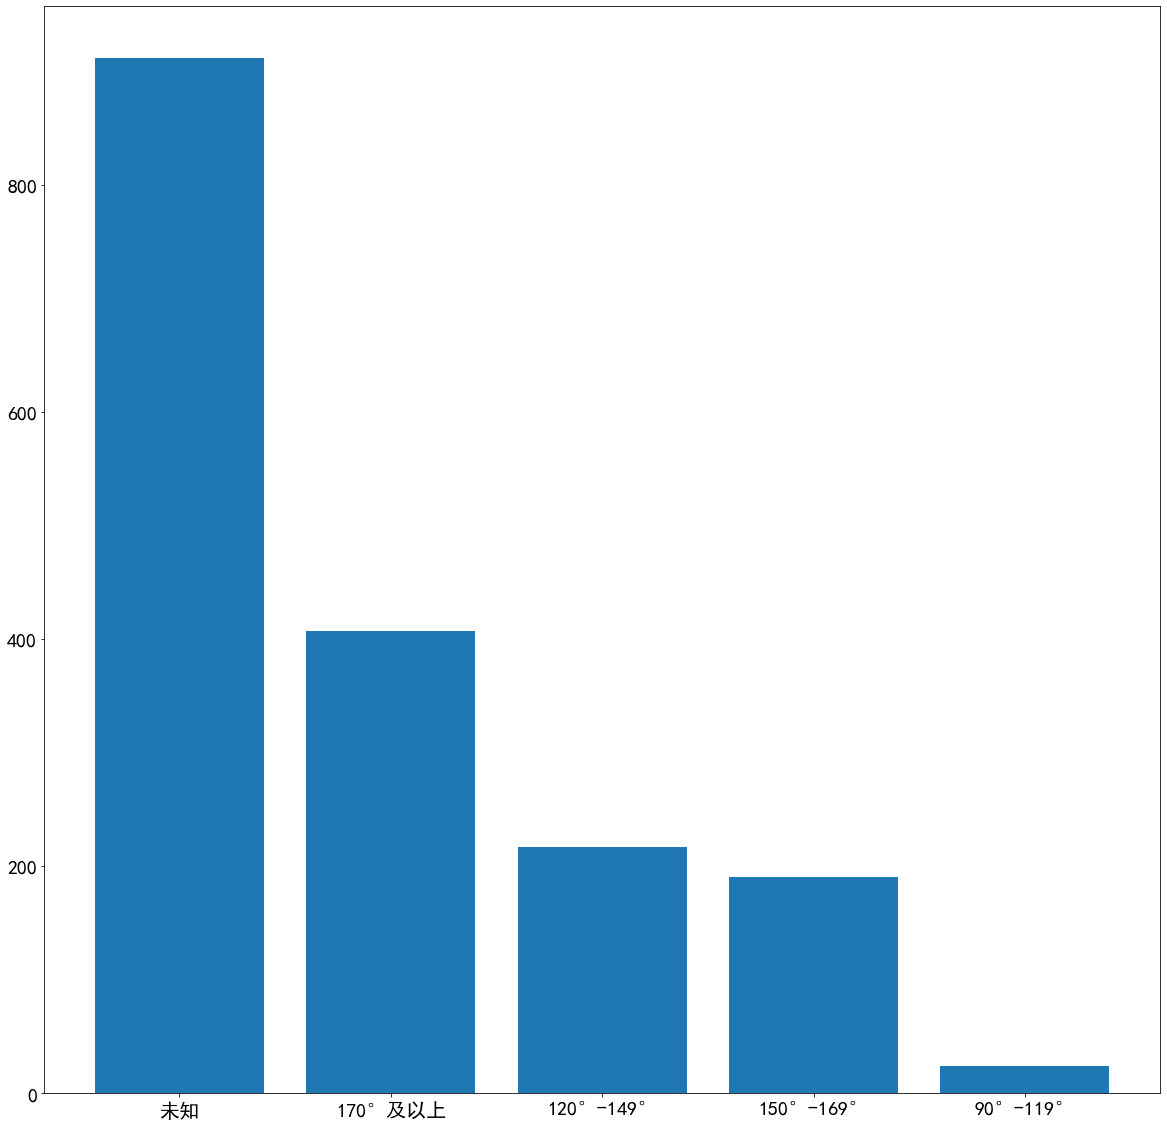

In [18]:
# 拍摄角度
record['拍摄角度'].fillna('未知', inplace = True)
plt.figure(figsize=(20,20))  
plt.pie(record['拍摄角度'].value_counts(),autopct='%1.1f%%',labels=record['拍摄角度'].value_counts().keys())
plt.show()
plt.figure(figsize=(20,20))  
plt.bar(record['拍摄角度'].value_counts().keys(),record['拍摄角度'].value_counts())
plt.show()

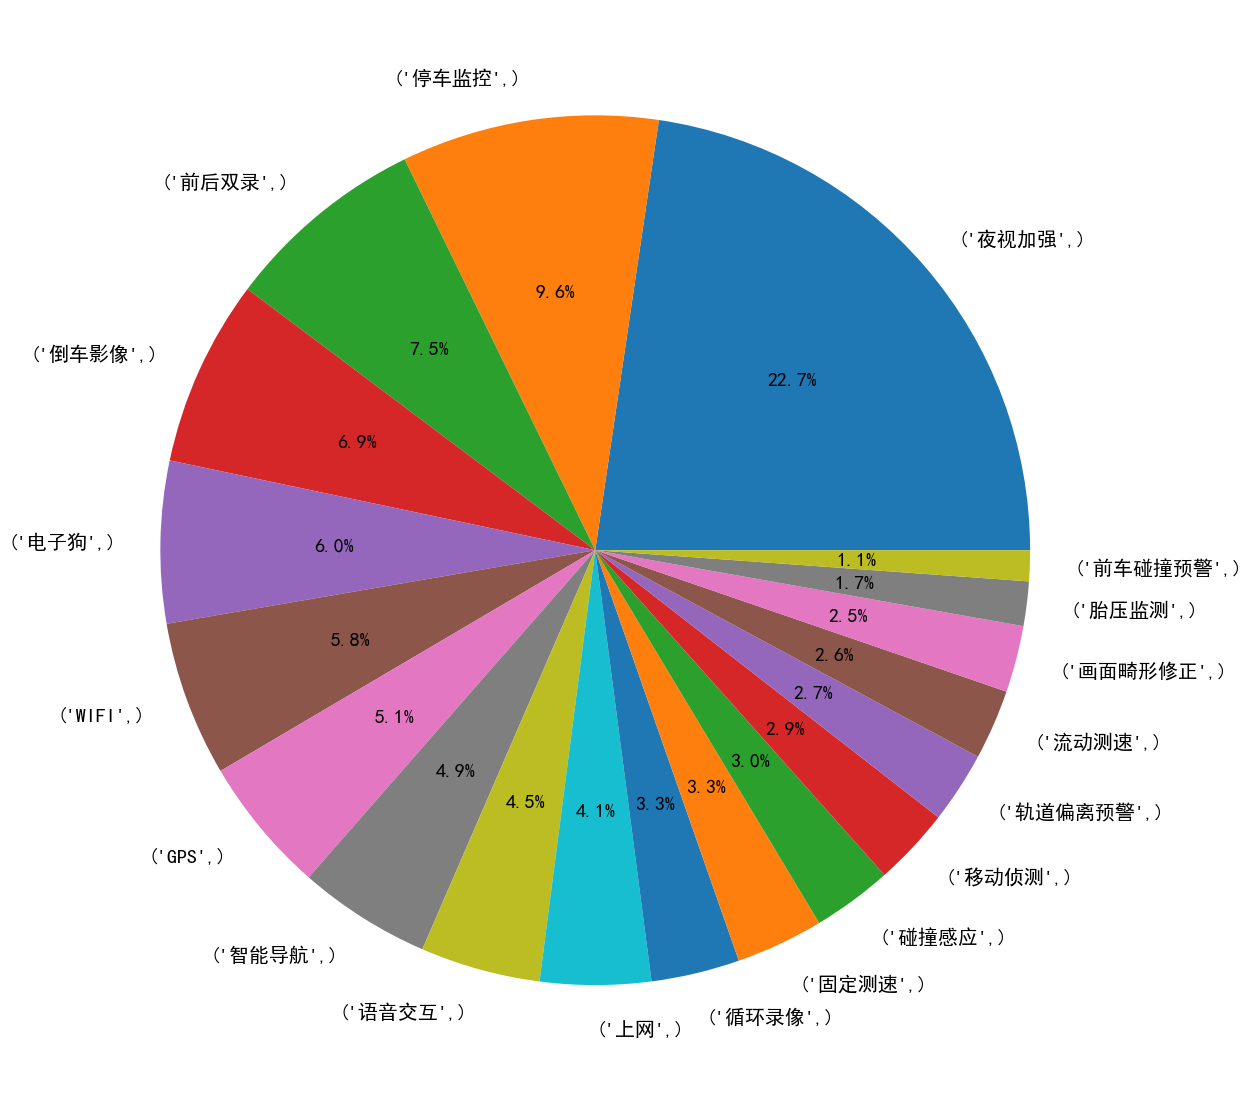

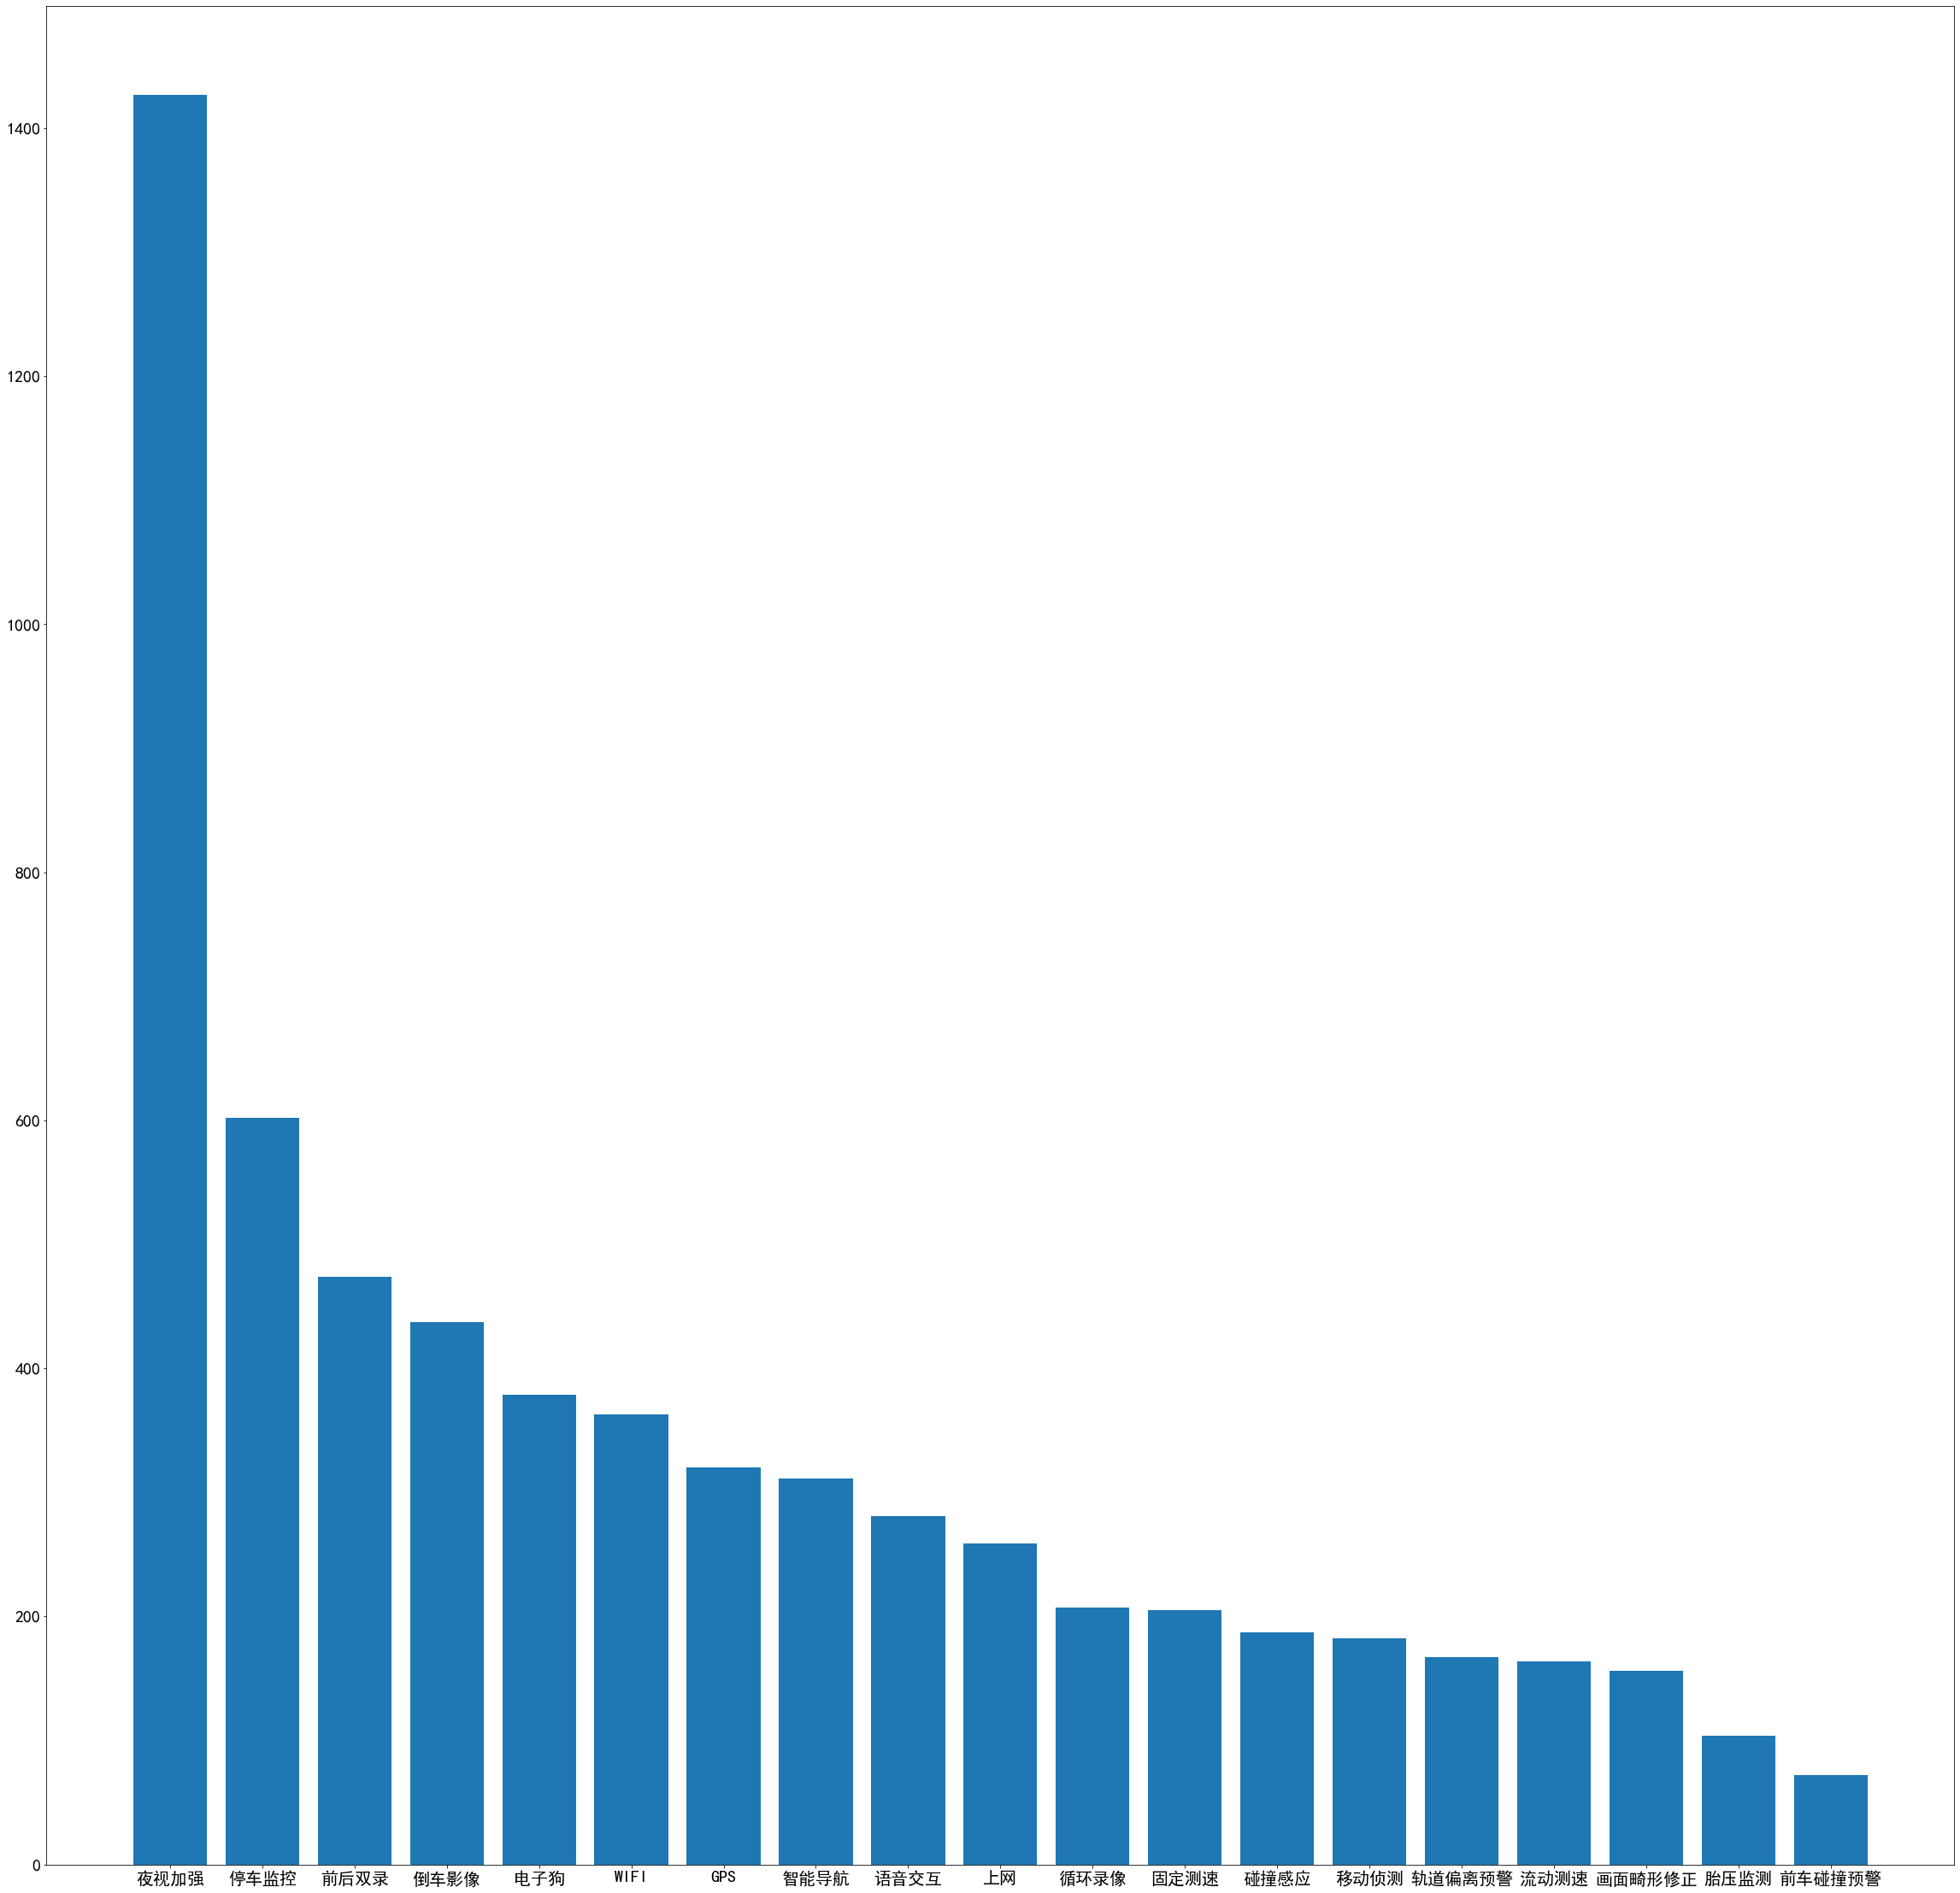

In [19]:
# 功能
ability = record['功能'].tolist()
for i in range(len(ability)):
    if pd.isna(ability[i]) == False:
        ability[i] = ability[i].split('，')
    else:
        ability[i] = []
all_ability_kind = []
for a in ability:
    all_ability_kind = all_ability_kind + a

plt.figure(figsize=(20,20))  
plt.pie(pd.DataFrame(all_ability_kind).value_counts(),autopct='%1.1f%%',labels=pd.DataFrame(all_ability_kind).value_counts().keys())
plt.show()
plt.figure(figsize=(40,40))  
plt.bar(pd.DataFrame(all_ability_kind)[0].value_counts().keys(),pd.DataFrame(all_ability_kind)[0].value_counts())
plt.show()

### 数据预处理

In [20]:
record = pd.read_excel('行车记录仪.xlsx')
# 数据处理
# 去除数据不全的条目

# 价格是不能为空的，如果价格为空则去掉
record = record.dropna(axis = 0,subset = ['价格'])
# 将品牌为空的条目去掉
record = record.dropna(axis = 0,subset = ['品牌'])
# 发现一条数据：便携式移动充电宝 黄色	29.00	移路通（Yilutong）		按键	无屏幕	150°-169°	夜视加强	1296P	通用双镜头	20.0kg
record = record.drop(record[record['商品毛重'] == '20.0kg'].index)

# 缺失值处理
record['操作方式'].fillna('未知', inplace = True)
record['分辨率'].fillna('未知', inplace = True)
record['拍摄角度'].fillna('未知', inplace = True)
record['安装方式'].fillna('其他', inplace = True)
record['商品产地'].fillna('未知', inplace = True)
# lost_price_brand = ''
# record['价格'].fillna(record[record['品牌'] == lost_price_brand]['价格'].mean())
# record['功能'].fillna('', inplace = True)
# 商品产地为空的超过了2/3，并且非空的大部分是“中国大陆”，所以去掉
for index,row in record.iterrows():
    if row['屏幕尺寸'] == '无屏幕':
        record.loc[index,'屏幕尺寸'] = 0.0
    else:
        record.loc[index,'屏幕尺寸'] = float(row['屏幕尺寸'].split("英寸")[0])
    record.loc[index,'商品毛重'] = float(row['商品毛重'].split("g")[0])
    record.loc[index,'评论数'] = int(row['评论数'].split('+')[0])
record['商品毛重'] = record['商品毛重'].astype('float')
# 异常值处理
# 发现一条数据：便携式移动充电宝 黄色	29.00	移路通（Yilutong）		按键	无屏幕	150°-169°	夜视加强	1296P	通用双镜头	20.0kg
record.drop(record[record['商品毛重'] == '20.0kg'].index)
# 商品毛重有几个值特别大
print(record.describe()['商品毛重'])
weight_list = list(record['商品毛重'])
weight_list.sort(reverse = True)
print(weight_list[0:10])
record = record.drop(record[record['商品毛重'] >= 100000].index)
print(record.describe()['商品毛重'])

count      1751.000000
mean        942.510565
std        4444.109478
min          10.000000
25%         400.000000
50%        1000.000000
75%        1000.000000
max      155000.000000
Name: 商品毛重, dtype: float64
[155000.0, 100000.0, 15000.0, 10000.0, 10000.0, 10000.0, 10000.0, 8000.0, 5000.0, 3800.0]
count     1749.000000
mean       797.790738
std        748.745643
min         10.000000
25%        400.000000
50%       1000.000000
75%       1000.000000
max      15000.000000
Name: 商品毛重, dtype: float64


In [21]:

keys = ['品牌','操作方式','安装方式','价格','屏幕尺寸','分辨率','商品毛重','拍摄角度','功能']
lost = []
lost_dict = {'品牌':0,'操作方式':0,'安装方式':0,'价格':0,'屏幕尺寸':0,'分辨率':0,'商品毛重':0,'拍摄角度':0,'功能':0}
for index,row in record.iterrows():
    sum = 0
    for key in keys:
        if pd.isna(row[key]):
            sum += 1
            lost_dict[key] += 1
    lost.append(sum)

s = set(lost)
dict={}
for item in s:
    dict.update({item:lost.count(item)})
print(dict)
print(lost_dict)
# 所以最终入选的属性为['品牌','操作方式','安装方式','价格','屏幕尺寸','分辨率','商品毛重','拍摄角度','功能']

{0: 1712, 1: 37}
{'品牌': 0, '操作方式': 0, '安装方式': 0, '价格': 0, '屏幕尺寸': 0, '分辨率': 0, '商品毛重': 0, '拍摄角度': 0, '功能': 37}


### 数据编码

In [22]:

enc = OneHotEncoder(handle_unknown='ignore')
feature_onehot = ['品牌','操作方式','安装方式']
feature_num = ['价格','屏幕尺寸','商品毛重']
feature_label = ['拍摄角度','分辨率']
feature_manyhot = ['功能']


In [23]:
# 独热编码
for index,row in record.iterrows():
    if type(row['品牌']) != str:
        record.loc[index,'品牌'] = str(row['品牌'])
enc = OneHotEncoder(handle_unknown='ignore')
feature_onehot = ['品牌','操作方式','安装方式']
record_partial = record[feature_onehot]
record_array = np.array(record_partial).tolist()
data1 = enc.fit_transform(record_array).toarray().tolist()

In [24]:
# 多热编码
ability = record['功能'].tolist()
for i in range(len(ability)):
    if pd.isna(ability[i]) == False:
        ability[i] = ability[i].split('，')
    else:
        ability[i] = []
all_ability_kind = []
for a in ability:
    all_ability_kind = all_ability_kind + a

ability_kind = list(set(all_ability_kind))
vector_len = len(ability_kind)
print(ability_kind)
data4 = []
for a in ability:
    if len(a) == 0:
        data4.append([0]*19)
    else:
        vector = [0]*19
        for i in range(len(ability_kind)):
            if ability_kind[i] in a:
                vector[i] = 1
        data4.append(vector)

['流动测速', '固定测速', '电子狗', '轨道偏离预警', '倒车影像', '上网', 'GPS', '语音交互', 'WIFI', '前车碰撞预警', '夜视加强', '智能导航', '前后双录', '移动侦测', '胎压监测', '画面畸形修正', '碰撞感应', '停车监控', '循环录像']


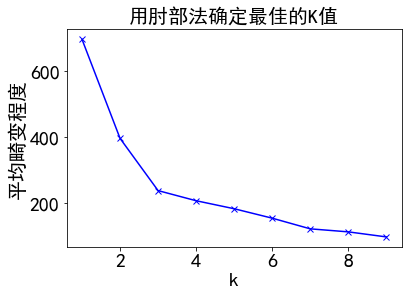

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


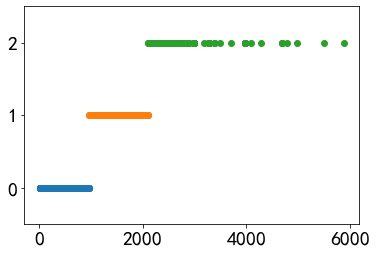

In [25]:
# 数值编码

def getK(X):
    K = range(1, 10)
    X = np.array(X).reshape(len(X),1)
    mean_list = []
    for k in K:
        kmeans = KMeans(n_clusters=k,n_init=10)
        kmeans.fit(X)
        # print(np.sum(np.min(cdist(X, kmeans.cluster_centers_, metric='euclidean'), axis=1)))
        mean_list.append(
                np.sum(np.min(cdist(X, kmeans.cluster_centers_, metric='euclidean'), axis=1))
            / X.shape[0])
    plt.plot(K, mean_list, 'bx-')
    plt.xlabel('k',size=20)
    plt.ylabel(u'平均畸变程度', size=20)
    plt.title(u'用肘部法确定最佳的K值', size=20)
    plt.show()
def cluster_plot(data,d, k):
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    plt.figure(figsize=(6, 4))
    for j in range(0, k):
        plt.plot(data[d == j], [j for i in d[d == j]], 'o')

    plt.ylim(-0.5, k - 0.5)
    return plt
def cluster(data, k): 

    # k=5
    kmodel = KMeans(n_clusters=k)
    kmodel.fit(np.array(data).reshape(len(data),1))
    c = pd.DataFrame(kmodel.cluster_centers_, columns=list('a')).sort_values(by='a')
    # rolling_mean表示移动平均，即用当前值和前2个数值取平均数，
    # 由于通过移动平均，会使得第一个数变为空值，因此需要使用.iloc[1:]过滤掉空值。
    # w = pd.rolling_mean(c, 2).iloc[1:]
    w = c.rolling(2).mean().iloc[1:]
    w = [0] + list(w['a']) + [data.max()]
    d5 = pd.cut(data, w, labels=range(k))

    cluster_plot(data,d5, k).show()
    
    return(kmodel.predict(np.array(data).reshape(len(data),1))), kmodel
getK(record['价格'])
record['价格'],price_model = cluster(record['价格'],3)
data2 = np.array(record[feature_num]).tolist()


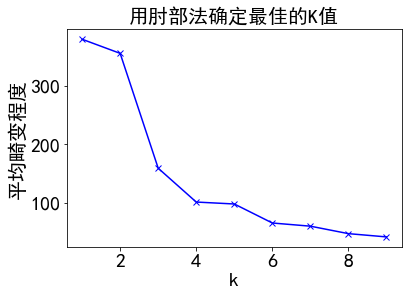

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


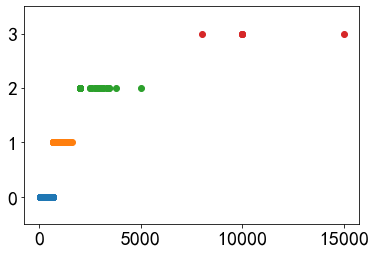

In [26]:
# 商品毛重
getK(record['商品毛重'])
record['商品毛重'],weight_model = cluster(record['商品毛重'],4)

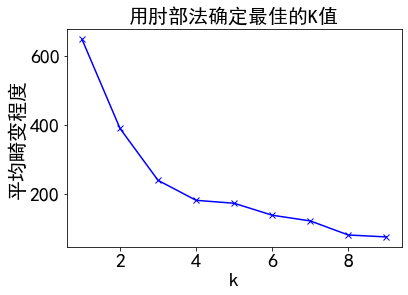

c:\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


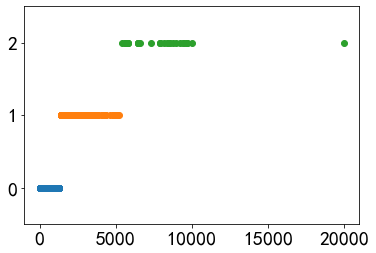

In [27]:
# 评论数
getK(sale)
temp = record.copy()
temp['评论数'],sale_model = cluster(temp['评论数'],3)
Y = list(temp['评论数'])

In [28]:
weight_model.predict(np.array([5000]).reshape(-1, 1))
# record['商品毛重']

array([0])

In [29]:
# label编码 主要针对离散取值，但其语义有大小关系
temp = record.copy()
temp.replace({'90°-119°':1,'120°-149°':2,'150°-169°': 3, '170°及以上': 4, '未知': 0}, inplace = True, regex = True)
temp.replace({'480P':1,'720p':2,'1080p': 3, '1296P': 4, '1440P': 5,'2K及以上':6,'未知':0}, inplace = True, regex = True)
data3 = np.array(temp[feature_label]).tolist()

In [30]:

X = []
for i in range(len(data1)):
    X.append(data1[i] + data2[i] + data3[i] + data4[i])
# def distribution_analysis(sale):

# Y = []
# sale = record['评论数'].tolist()
# sale = [int(s.split('+')[0]) for s in sale]
# plt.figure(figsize=(50,20))
# # sns.countplot(sale)
# sns.countplot(list(filter(lambda x: x != 0, sale)))
# # sns.kdeplot(sale, shade=True)
# # sns.distplot(sale)
# # 发现0占了很大部分，所以去掉0
# bins = np.percentile(list(filter(lambda x: x != 0, sale)), [20, 40, 60, 80]) 
# print(bins)
# bins = list(bins).insert(0,0)
# Y = list(np.digitize(sale, [1,600,1000]))
Y_labels = list(set(Y))
print(set(Y_labels))
# sns.distplot(list(filter(lambda x: x != 0, sale)))
# for s in sale:
#     num = classify(int(s.split('+')[0]))
#     Y.append(num)
cleandata = pd.DataFrame(record)
# record
# ability_kind

{0, 1, 2}


In [31]:
# 将编码映射回属性
# ['品牌':[0:170],'操作方式':[171:173],'安装方式':[174:181],'价格':[182],'屏幕尺寸':[183],'商品毛重':[184],'拍摄角度':[185],'分辨率':[186],'功能':[187:205]]
def decode(x_vector):
    decode_dict = {}
    onehot_decode = enc.inverse_transform(np.array(x_vector[0:182]).reshape(1, -1))
    print(type(onehot_decode[0][1]))
    view_dict = {1:'90°-119°',2:'120°-149°',3:'150°-169°', 4:'170°及以上', 0:'未知'}
    resolution_dict = {1:'480P',2:'720p',3:'1080p', 4:'1296P',5: '1440P',6:'2K及以上',0:'未知'}
    decode_dict['品牌'] = onehot_decode[0][0]
    decode_dict['操作方式'] = onehot_decode[0][1]
    decode_dict['安装方式'] = onehot_decode[0][2]
    decode_dict['价格'] = x_vector[182]
    decode_dict['屏幕尺寸'] = x_vector[183]
    decode_dict['商品毛重'] = x_vector[184]
    decode_dict['拍摄角度'] = view_dict[x_vector[185]]
    decode_dict['分辨率'] = resolution_dict[x_vector[186]]
    decode_dict['功能'] = []
    ability_list = x_vector[187:206]
    for i in range(len(ability_list)):
        if ability_list[i] == 1:
            decode_dict['功能'].append(ability_kind[i])
    return decode_dict
decode(X[1])

<class 'str'>


{'品牌': ' 米家（MIJIA）',
 '操作方式': '按键',
 '安装方式': '通用单镜头',
 '价格': 2,
 '屏幕尺寸': 3.0,
 '商品毛重': 366.0,
 '拍摄角度': '150°-169°',
 '分辨率': '1080p',
 '功能': ['夜视加强']}

### 分类（分析影响行车记录仪销量的前3个主要因素，给出其销量分类的模型，分析模型的性能。）

In [46]:
report = {}
def get_train_report(y_test,y_pred,model):
    #对模型进行评估
    accuracy = metrics.accuracy_score(y_test,y_pred)
    print('%s_accuracy：%.3f'% (model,accuracy))
    precision = metrics.precision_score(y_test,y_pred,average="micro")
    print("%s_precision: %.3f"% (model,precision))
    recall = metrics.recall_score(y_test,y_pred,average="micro")
    print('%s_recall：%.3f'% (model,recall))
    f1_score = metrics.f1_score(y_test,y_pred,average="micro")
    print('%s_F1：%.3f'% (model,f1_score))
    labels = Y_labels
    ytest = label_binarize(y_test, classes=labels)
    ypred = label_binarize(y_pred, classes=labels)
    roc = metrics.roc_auc_score(ytest,ypred,multi_class='ovr',average="micro")
    print('%s_roc：%.3f'% (model,roc))
    mse = metrics.mean_squared_error(y_test,y_pred)
    print('%s_mse：%.3f'% (model,mse))
    return {'accuracy':accuracy,'precision':precision,'recall':recall,'f1_score':f1_score,'roc':roc,'mse':mse}
   

In [47]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=100)
# 训练随机森林模型
RFC = RandomForestClassifier(n_estimators=500,bootstrap=True,random_state=0)
RFC.fit(x_train,y_train)
# 预测
RFC_pred = RFC.predict(x_test)
#对模型进行评估
report['RFC'] = get_train_report(y_test,RFC_pred,'RFC')

RFC_accuracy：0.907
RFC_precision: 0.907
RFC_recall：0.907
RFC_F1：0.907
RFC_roc：0.930
RFC_mse：0.322


In [48]:
RFC = RandomForestClassifier(bootstrap=True,random_state=0)
param_grid = {
    'n_estimators': [10, 500],
    # 'max_depth' : [10,11,12,13,14,15],
    # 'criterion' :['gini', 'entropy']
}
kfold = KFold(n_splits=10, random_state=100, shuffle=True)
CV_RFC = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= kfold, scoring='accuracy')
CV_RFC.fit(x_train, y_train)
print(CV_RFC.best_params_)
print(CV_RFC.best_score_)
print(CV_RFC.best_estimator_)

{'n_estimators': 500}
0.9158469945355192
RandomForestClassifier(n_estimators=500, random_state=0)


In [49]:
CART = DecisionTreeClassifier(criterion = 'entropy')
param_grid = {
    'n_estimators': [10, 500],
    'max_depth' : [10,11,12,13,14,15],
    # 'criterion' :['gini', 'entropy']
}
kfold = KFold(n_splits=10, random_state=100, shuffle=True)
CV_RFC = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= kfold, scoring='accuracy')
CV_RFC.fit(x_train, y_train)
print(CV_RFC.best_params_)
print(CV_RFC.best_score_)
print(CV_RFC.best_estimator_)

{'max_depth': 12, 'n_estimators': 10}
0.9085365853658536
RandomForestClassifier(max_depth=12, n_estimators=10, random_state=0)


In [50]:
# 训练ID3模型
ID3 = DecisionTreeClassifier(criterion = 'entropy')
ID3.fit(x_train,y_train)
# 预测
ID3_pred = ID3.predict(x_test)
#对模型进行评估
report['ID3'] = get_train_report(y_test,ID3_pred,'ID3')
# 画图
# feature_names = ['品牌','操作方式','安装方式','价格','屏幕尺寸','分辨率','商品毛重','拍摄角度','功能']
# class_names = [0,1,2,3,4]
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置
# plt.figure(figsize=(100,100))
# plot_tree(
#     ID3,
#     # feature_names = feature_names,
#     # class_names = class_names,
#     filled=True
# )
# plt.show()

ID3_accuracy：0.865
ID3_precision: 0.865
ID3_recall：0.865
ID3_F1：0.865
ID3_roc：0.899
ID3_mse：0.438


CART_accuracy：0.878
CART_precision: 0.878
CART_recall：0.878
CART_F1：0.878
CART_roc：0.909
CART_mse：0.408


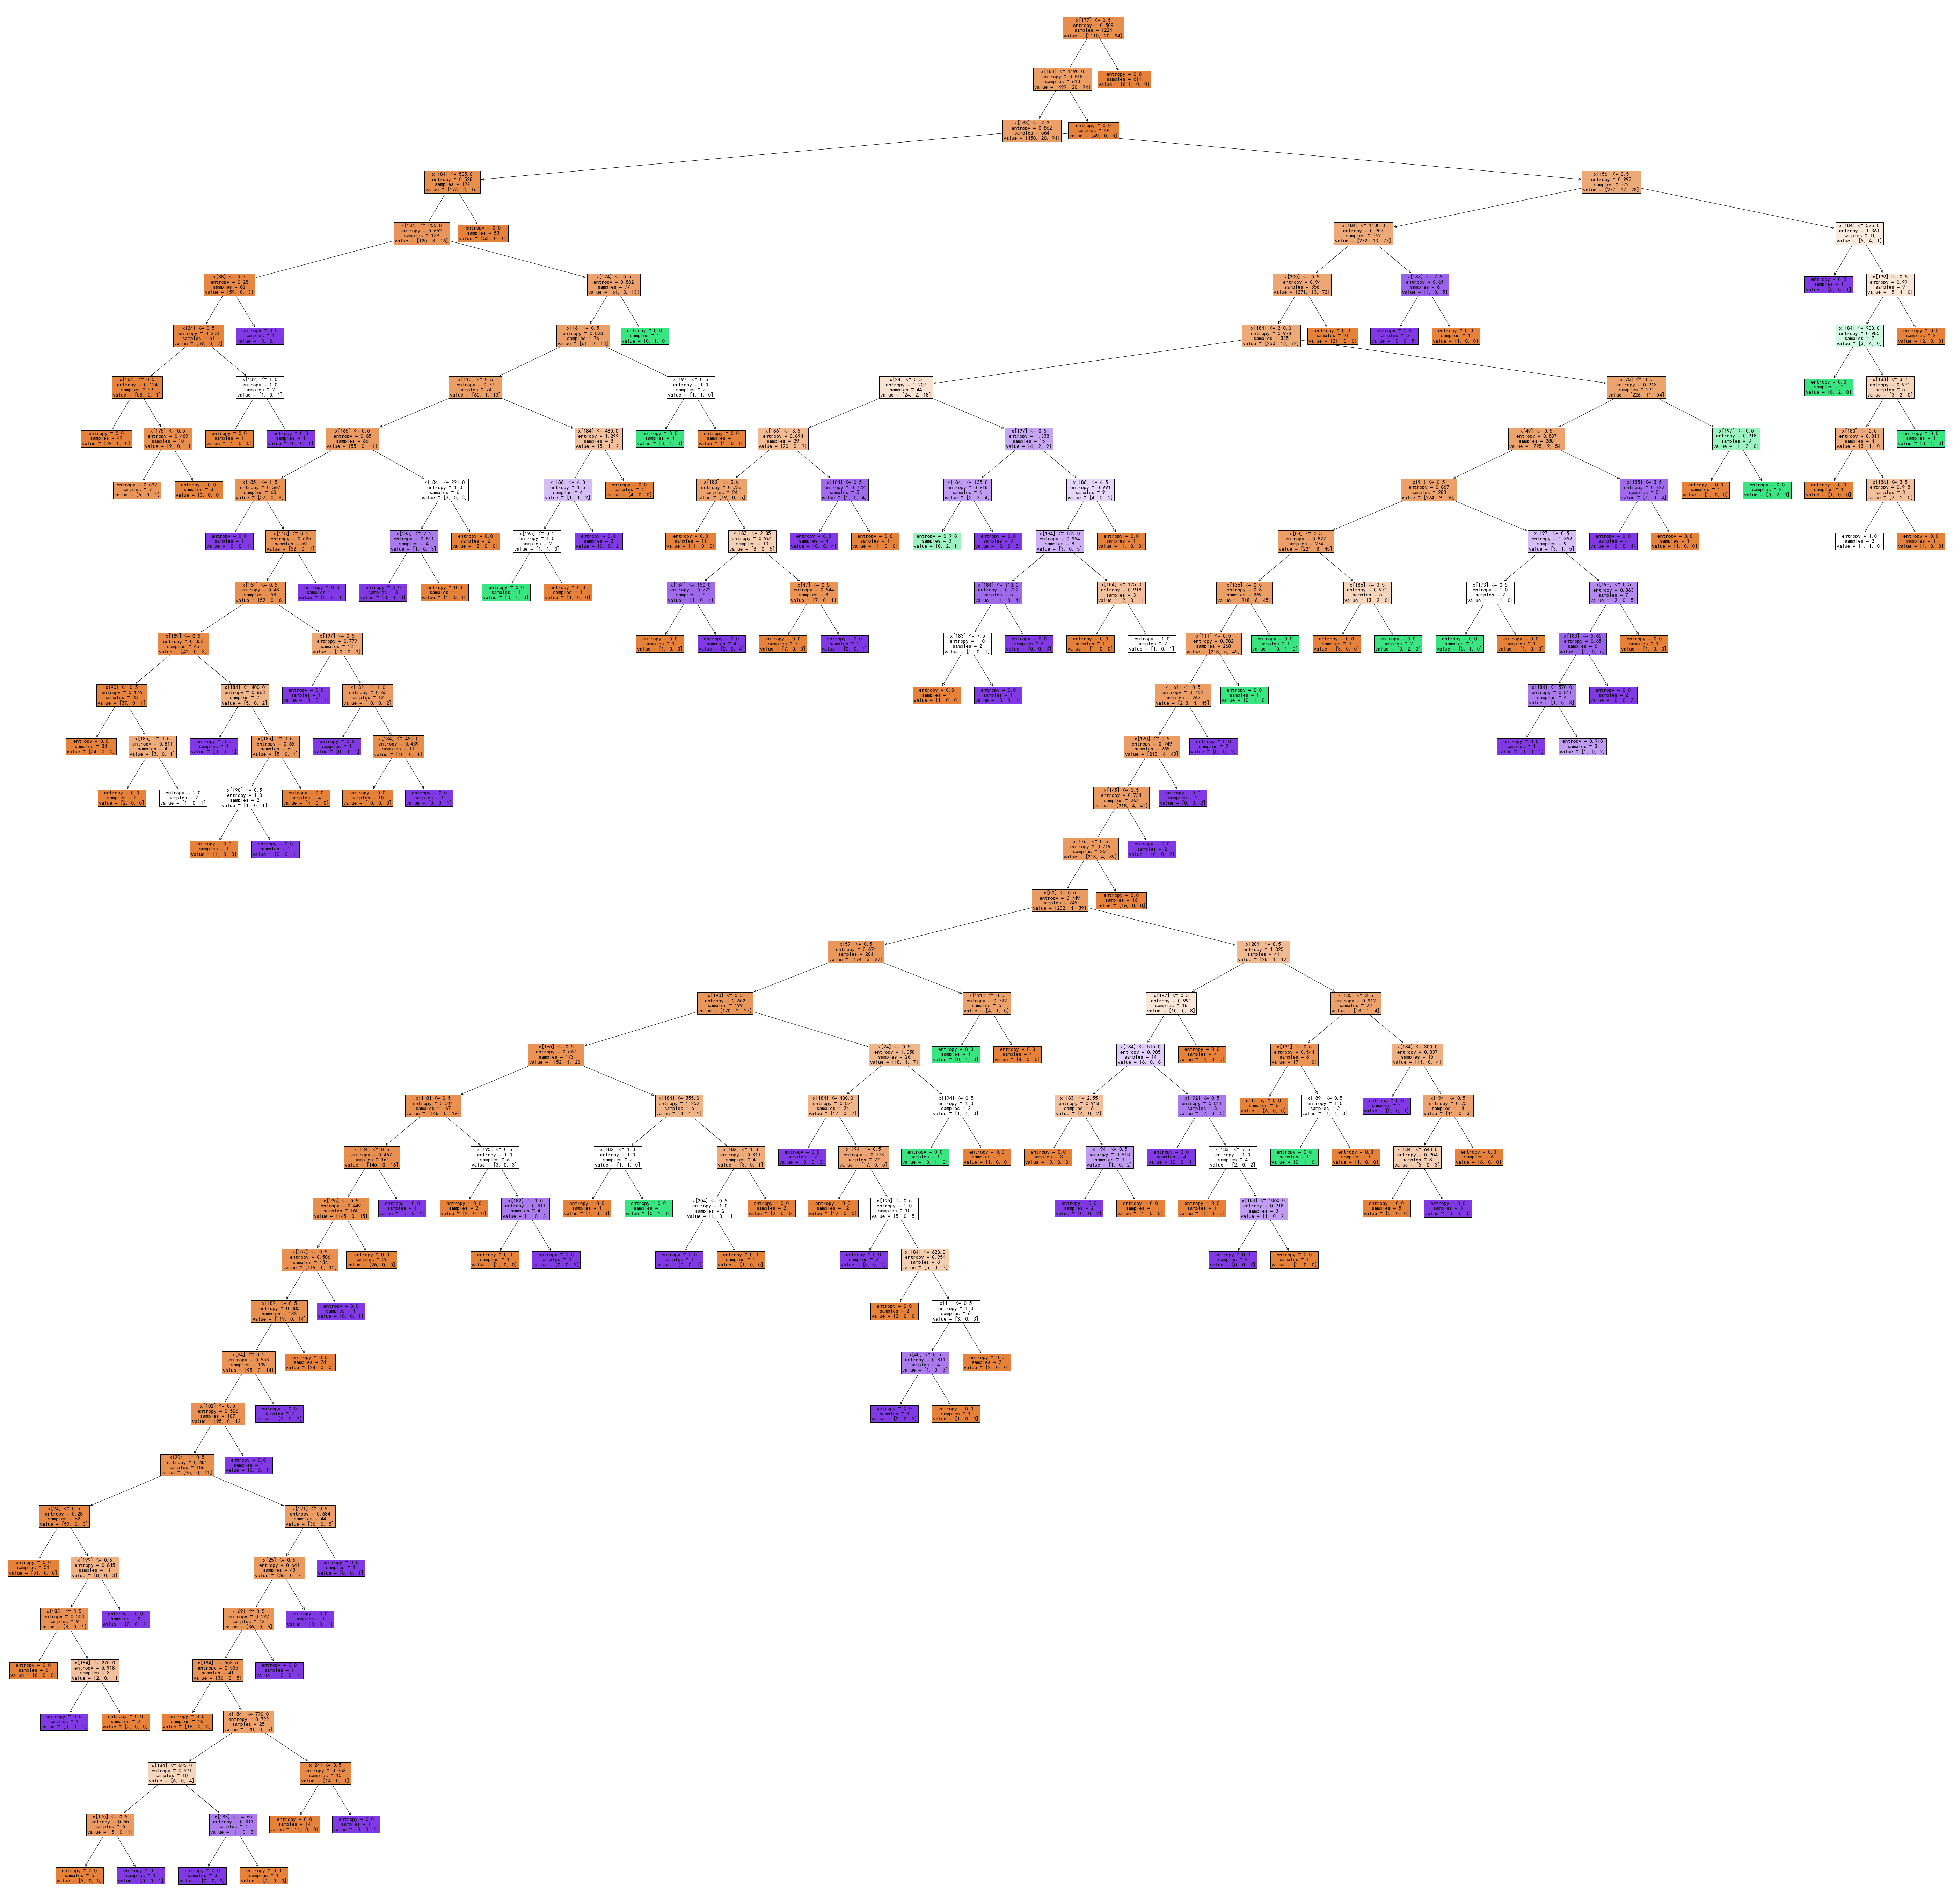

In [51]:
# 训练CART模型
CART = DecisionTreeClassifier(criterion = 'entropy')
CART.fit(x_train,y_train)
# 预测
CART_pred = CART.predict(x_test)
#对模型进行评估
report['CART'] = get_train_report(y_test,CART_pred,'CART')
# 画图
plt.figure(figsize=(100,100))
plot_tree(
    CART,
    # feature_names = feature_names,
    # class_names = class_names,
    filled=True
)
plt.show()

In [52]:
# 神经网络
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(max_iter=500)
MLP.fit(x_train, y_train)
MLP_pred = MLP.predict(x_test)
# print(metrics.classification_report(y_test, MLP_pred)) 
#对模型进行评估
report['MLP'] = get_train_report(y_test,MLP_pred,'MLP')

MLP_accuracy：0.899
MLP_precision: 0.899
MLP_recall：0.899
MLP_F1：0.899
MLP_roc：0.924
MLP_mse：0.352


In [53]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
log_reg = LogisticRegression(max_iter=500,solver='lbfgs', multi_class='multinomial')
log_reg.fit(x_train,y_train) 
log_reg_pred = log_reg.predict(x_test)
report['log_reg'] = get_train_report(y_test,log_reg_pred,'log_reg')

log_reg_accuracy：0.886
log_reg_precision: 0.886
log_reg_recall：0.886
log_reg_F1：0.886
log_reg_roc：0.914
log_reg_mse：0.406


c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
log_reg2 = LogisticRegression(max_iter=10000,solver='lbfgs', multi_class='multinomial')
ovo = OneVsOneClassifier(log_reg2)#传入二分类器
ovo.fit(x_train,y_train)
ovo_pred = ovo.predict(x_test)
report['ovo'] = get_train_report(y_test,ovo_pred,'ovo')

ovo_accuracy：0.891
ovo_precision: 0.891
ovo_recall：0.891
ovo_F1：0.891
ovo_roc：0.919
ovo_mse：0.383


In [55]:
log_reg3 = LogisticRegression(max_iter=10000,solver='lbfgs', multi_class='multinomial')
ovr = OneVsRestClassifier(log_reg3)
ovr.fit(x_train,y_train)
ovr_pred = ovr.predict(x_test)
report['ovr'] = get_train_report(y_test,ovr_pred,'ovr')
ovr.estimators_[0].coef_

ovr_accuracy：0.895
ovr_precision: 0.895
ovr_recall：0.895
ovr_F1：0.895
ovr_roc：0.921
ovr_mse：0.368


array([[-5.29758355e-01,  0.00000000e+00,  1.51890882e-01,
         0.00000000e+00,  0.00000000e+00,  3.30868236e-01,
         1.28062935e-02,  2.67947687e-01,  6.09237138e-02,
         0.00000000e+00,  2.68661993e-02,  4.13700361e-01,
         1.41849439e-01,  4.32929525e-02,  1.51232728e-01,
         0.00000000e+00, -1.61209641e-01,  1.71609355e-01,
         3.80601488e-01,  5.97978579e-02,  7.09266392e-01,
         8.56985289e-02,  6.17807591e-02,  0.00000000e+00,
        -4.60116725e-01, -4.90627766e-01,  1.11172310e-01,
         6.15300096e-02,  0.00000000e+00,  0.00000000e+00,
         1.64835990e-02,  0.00000000e+00,  2.05518804e-01,
         6.26258436e-01,  9.37433150e-04,  4.17358133e-01,
         4.69718646e-02,  1.18730263e-01,  2.24043194e-02,
         5.27776189e-01,  4.90216100e-01,  0.00000000e+00,
         1.25119912e-01,  0.00000000e+00,  1.66702722e-02,
         1.50254516e-01,  1.05363564e-01,  2.89747897e-01,
         1.44009383e-01, -9.56512393e-01, -3.37097733e-0

In [56]:
# 交叉验证
# feature_names = cleandata.columns.values.tolist()[:-1]
# class_names = ['D-风险客户', 'C-普通客户', 'B-良好客户', 'A-优质客户']

# kfold = KFold(n_splits=10, random_state=100, shuffle=True)
# results = cross_val_score(ID3, X, Y, cv=kfold, scoring='f1_macro')
# ID3_f1_score = metrics.f1_score(y_test,ID3_pred,average="micro")
# print('ID3_F1：%.3f'% ID3_f1_score)
# print("ID3_F1_cross：%.3f"% results.mean())

In [57]:
# RFC = RandomForestClassifier(random_state=0, class_weight = 'balanced')
# param_grid = {
#     'n_estimators': [100, 600],
#     'max_depth' : [10,11,12,13,14,15],
#     'criterion' :['gini', 'entropy']
# }
# CV_RFC = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= kfold, scoring='f1_macro')
# CV_RFC.fit(x_train, y_train)
# print(CV_RFC.best_params_)
# print(CV_RFC.best_score_)
# print(CV_RFC.best_estimator_)

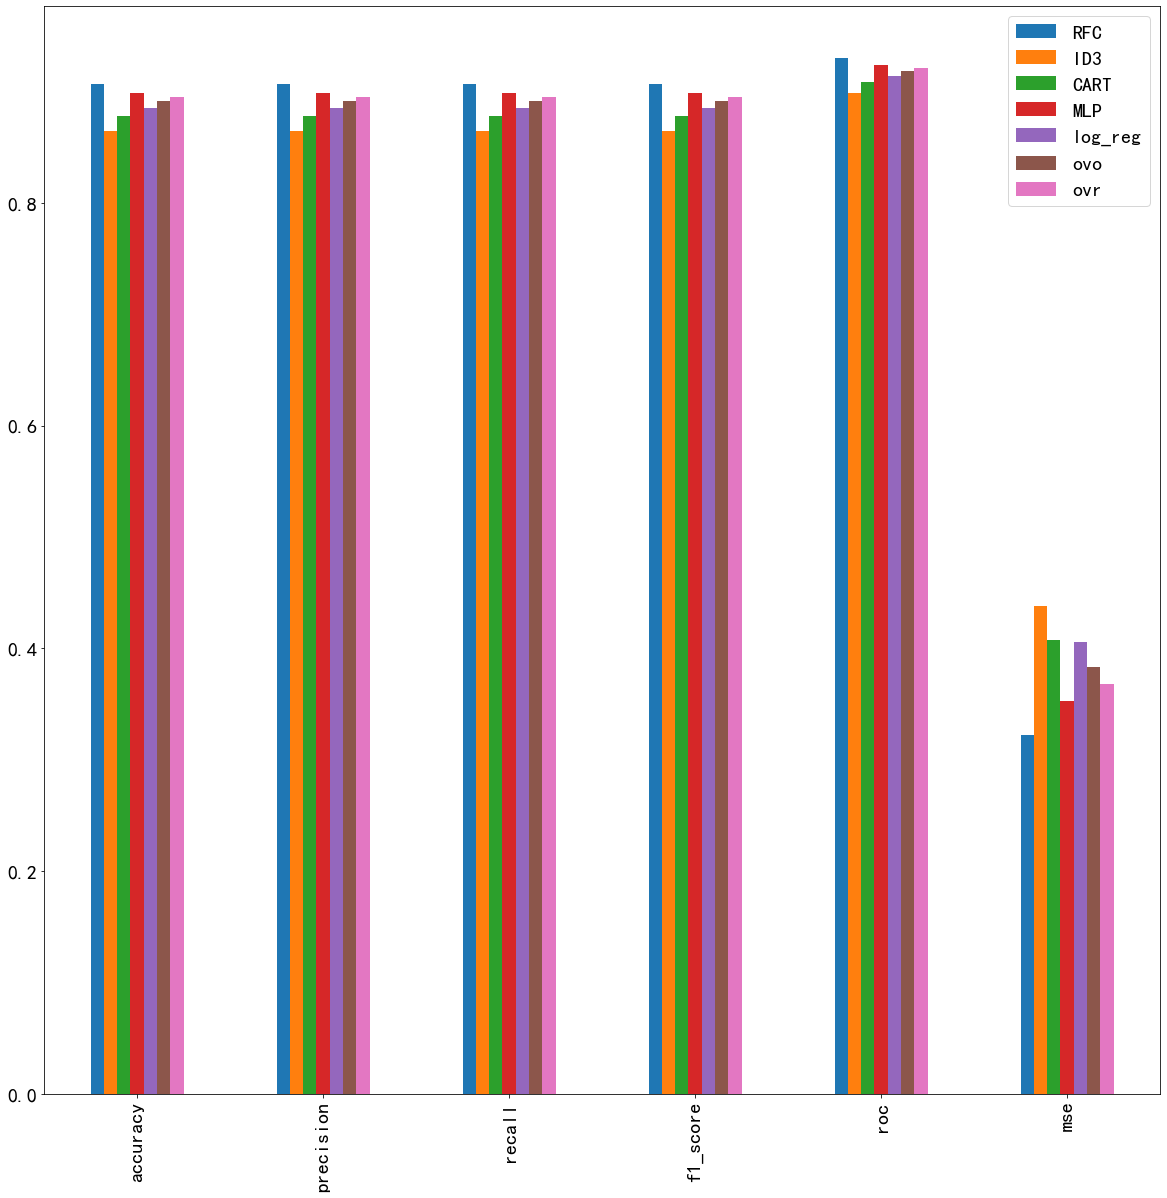

In [58]:
# 所有分类方法的对比
report_df = pd.DataFrame(report)
report_df
report_df.plot(kind='bar',figsize=(20,20))
plt.show()

In [59]:
# ['品牌':[0:170],'操作方式':[171:173],'安装方式':[174:181],'价格':[182],'屏幕尺寸':[183],'商品毛重':[184],'拍摄角度':[185],'分辨率':[186],'功能':[187:205]]
def get_feature_importance(feature_importances_):
    feature_importances_dict = {}
    feature_importances_dict['品牌'] = np.sum(feature_importances_[0:171])
    feature_importances_dict['操作方式'] = np.sum(feature_importances_[171:174])
    feature_importances_dict['安装方式'] = np.sum(feature_importances_[174:182])
    feature_importances_dict['价格'] = np.sum(feature_importances_[182])
    feature_importances_dict['屏幕尺寸'] = np.sum(feature_importances_[183])
    feature_importances_dict['商品毛重'] = np.sum(feature_importances_[184])
    feature_importances_dict['拍摄角度'] = np.sum(feature_importances_[185])
    feature_importances_dict['分辨率'] = np.sum(feature_importances_[186])
    feature_importances_dict['功能'] = np.sum(feature_importances_[187:206])
    return feature_importances_dict
print(get_feature_importance(RFC.feature_importances_))
# print(get_feature_importance(ID3.feature_importances_))

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# 和默认参数的随机森林对比
# _RFC = CV_RFC.best_estimator_
# _RFC.fit(x_train,y_train)
# # 预测
# _RFC_pred = _RFC.predict(x_test)
# #MLP
# _RFC_accuracy = metrics.accuracy_score(y_test,_RFC_pred)
# print('RFC_accuracy：%.3f'% RFC_accuracy)
# print('CV_RFC_accuracy：%.3f'% _RFC_accuracy)

### 聚类分析（对行车记录仪进行聚类分析，讨论每类行车记录仪的特点）

In [ ]:
# 相关函数
# 肘部分析
def getK_kmeans(X):
    K = range(1, 10)
    mean_list = []
    for k in K:
        kmeans = KMeans(n_clusters=k,n_init=10)
        kmeans.fit(X)
        # print(np.sum(np.min(cdist(X, kmeans.cluster_centers_, metric='euclidean'), axis=1)))
        mean_list.append(
                np.sum(np.min(cdist(X, kmeans.cluster_centers_, metric='euclidean'), axis=1))
            / X.shape[0])
    plt.plot(K, mean_list, 'bx-')
    plt.xlabel('k',size=20)
    plt.ylabel(u'平均畸变程度', size=20)
    plt.title(u'用肘部法确定最佳的K值', size=20)
    plt.show()
# 聚类可视化
def kmeans_visulization(data,num_clusters):
    plt.figure()
    plt.scatter(data[:,0], data[:,1], marker='o', 
            facecolors='none', edgecolors='k', s=30)
    x_min, x_max = min(data[:, 0]) - 1, max(data[:, 0]) + 1
    y_min, y_max = min(data[:, 1]) - 1, max(data[:, 1]) + 1
    plt.title('Input data')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())

    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
    kmeans.fit(data)

    step_size = 0.01

    x_min, x_max = min(data[:, 0]) - 1, max(data[:, 0]) + 1
    y_min, y_max = min(data[:, 1]) - 1, max(data[:, 1]) + 1
    x_values, y_values = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

    predicted_labels = kmeans.predict(np.c_[x_values.ravel(), y_values.ravel()])

    predicted_labels = predicted_labels.reshape(x_values.shape)
    plt.figure()
    plt.clf()
    plt.imshow(predicted_labels, interpolation='nearest',
               extent=(x_values.min(), x_values.max(), y_values.min(), y_values.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.scatter(data[:,0], data[:,1], marker='o', 
            facecolors='none', edgecolors='k', s=30)

    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:,0], centroids[:,1], marker='o', s=200, linewidths=3,
            color='k', zorder=10, facecolors='black')
    x_min, x_max = min(data[:, 0]) - 1, max(data[:, 0]) + 1
    y_min, y_max = min(data[:, 1]) - 1, max(data[:, 1]) + 1
    plt.title('Centoids and boundaries obtained using KMeans')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    return centroids
# kmeans聚类
def kmeans(data,num_clusters):
    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
    kmeans.fit(data)

    centroids = kmeans.cluster_centers_
    return centroids

[0.63115667 0.14165723]


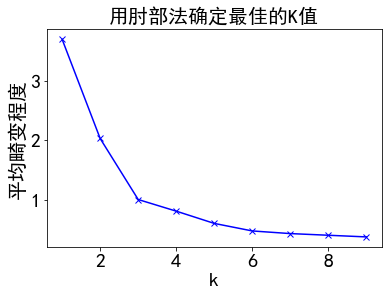

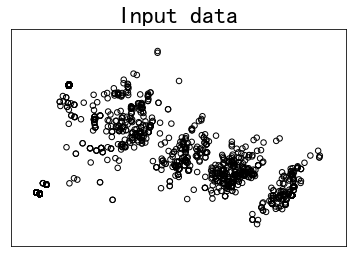

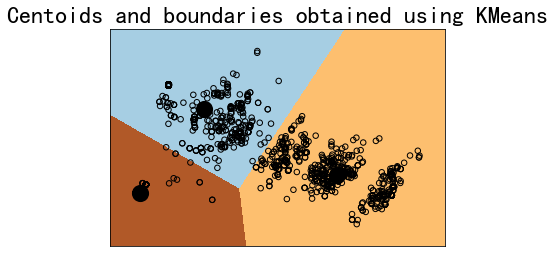

array([[-0.85612758,  2.54653584],
       [ 4.32318297, -0.42388231],
       [-3.34740977, -1.23500258]])

In [ ]:
# PCA降维
from sklearn.decomposition import PCA
def get_pca_array(data):
    X = data
    pca = PCA(n_components=2)
    pca.fit(X)
    print(pca.explained_variance_ratio_)
    return pca.fit_transform(X)
pca_array = get_pca_array(X)   
getK_kmeans(pca_array)
kmeans_visulization(pca_array,3)

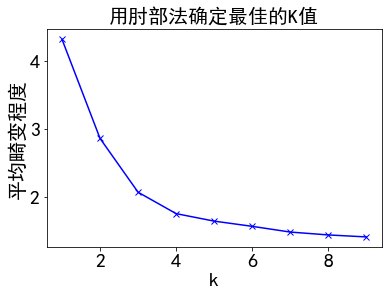

In [ ]:
# 高维数据用k-means聚类
# 肘部分析
getK_kmeans(np.array(X))
vector_array = np.array(X)
centroids = kmeans(vector_array,3)
# print(centroids)

In [ ]:
# 直接用高维数据
# 获得聚类中心周围的点的index
from scipy.spatial.distance import euclidean
import scipy.spatial.distance as dist
def get_distance(center,node):
    return dist.euclidean(center,node)
print(get_distance(centroids[0],[0]*206) , get_distance(centroids[0],[0]*206) , get_distance(centroids[2],[0]*206))
# get_distance(centroids[1],[0]*206)是离群值，比别的大很多，所以要去除
radius = (get_distance(centroids[0],[0]*206) + get_distance(centroids[0],[0]*206) + get_distance(centroids[2],[0]*206))/6
print(radius)

# radius = 3
def get_points_around(centroids,radius):
    points_around = {}
    for i in range(len(centroids)):
        points_around[i] = []
    for i in range(len(vector_array)):
        for j in range(len(centroids)):
            distance = get_distance(centroids[j],vector_array[i])
            if distance < radius:
                points_around[j].append(i)
    # 计算覆盖率
    node_list = []
    sum = 0
    for i in range(len(centroids)):
        node_list += points_around[i]
        sum += len(points_around[i])
        print("聚类%d的点数:%d"%(i,len(points_around[i])))
    print("包含的点的总数%d 占总数据的%f"%(len(set(node_list)),len(set(node_list)) * 1.0/len(vector_array) * 1.0))
    print("重叠的数据:%d 占总数据的%f"%((sum - len(set(node_list)),(sum - len(set(node_list))) * 1.0/len(vector_array) * 1.0)))
    return points_around

# 发现三个集合没有重合的点
points_around = get_points_around(centroids,radius)

8.491966130576888 8.491966130576888 8.744640505362359
4.288095461086022
聚类0的点数:695
聚类1的点数:615
聚类2的点数:442
包含的点的总数1720 占总数据的0.983419
重叠的数据:32 占总数据的0.018296


In [ ]:
# 特征提取
from collections import Counter
import numpy as np
import itertools
# feature_onehot = ['品牌','操作方式','安装方式']
# feature_num = ['价格','屏幕尺寸','商品毛重']
# feature_label = ['拍摄角度','分辨率']
# feature_manyhot = ['功能']

# feature_onehot 对于其中的特征采取统计的方式，看一看最多的几个类别是什么

def compare_features(points_around):
    center_nodes = {}
    for i in range(len(points_around)):
        center_nodes[i] = record.iloc[points_around[i]]
    def get_top_member(feature, topK):
        return Counter(feature).most_common()[0:topK]
    def print_top_member(feature_key, topK):
        print('--------------'+feature_key+'-------------')
        for i in range(len(points_around)):
            print(get_top_member(center_nodes[i][feature_key],topK))
    
    # feature_num 使用求平均值
    def print_average(feature_key):
        print('--------------'+feature_key+'-------------')
        for i in range(len(points_around)):
            print(np.mean((center_nodes[i][feature_key])))
    
    print_top_member('品牌',5)
    print_top_member('操作方式',3)
    print_top_member('安装方式',3)
    print_average('价格')
    print_average('屏幕尺寸')
    print_average('商品毛重')
    # feature_label
    print_top_member('拍摄角度',3)
    print_top_member('分辨率',3)
    # feature_manyhot
    def print_top_ability(ability,topK):
        print('--------------ability-------------')
        for i in range(len(points_around)):
            ability_center = [ability[j] for j in points_around[i]]
            print(Counter(list(itertools.chain.from_iterable(ability_center))).most_common()[0:topK])
    print_top_ability(ability,5)
compare_features(points_around)

--------------品牌-------------
[(' 卡仕达', 146), (' 凌度（BLACKVIEW）', 87), (' 丁威特', 42), (' 捷渡（JADO）', 12), (' HYUNDAI', 12)]
[(' 靓知渝（liangzhiyu）', 39), (' 凌度（BLACKVIEW）', 30), (' 任e行', 26), (' 飞利浦（PHILIPS）', 24), ('360', 23)]
[(' 吉士野', 680), (' 凌度（BLACKVIEW）', 8), (' HYUNDAI', 6), (' 仙人指路', 4), (' 丁威特', 3)]
--------------操作方式-------------
[('未知', 219), ('触屏', 176), ('按键', 56)]
[('按键', 554), ('触屏', 63)]
[('未知', 702), ('按键', 2)]
--------------安装方式-------------
[('通用双镜头', 180), ('专车专用式', 171), ('绑带式', 37)]
[('通用单镜头', 282), ('通用双镜头', 184), ('专车专用双镜头', 80)]
[('专车专用式', 693), ('其他', 9), ('通用双镜头', 1)]
--------------价格-------------
0.8891352549889135
0.15883306320907617
1.1065340909090908
--------------屏幕尺寸-------------
7.36940133037694
2.223338735818475
7.9616477272727275
--------------商品毛重-------------
0.8780487804878049
0.7293354943273906
1.7883522727272727
--------------拍摄角度-------------
[('未知', 219), ('170°及以上', 112), ('150°-169°', 70)]
[('170°及以上', 280), ('120°-149°', 188), ('150°-169°', 132)

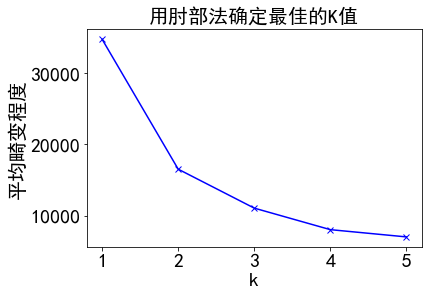

In [ ]:
from kmodes.kprototypes import KPrototypes
def getK_kprototypes(X):
    K = range(1, 6)
    SSE = []
    for k in K:
        kprototypes = KPrototypes(n_clusters=k, init='Cao')
        kprototypes.fit_predict(pd.DataFrame(X), categorical=[1])
        # print(np.sum(np.min(cdist(X, kmeans.cluster_centers_, metric='euclidean'), axis=1)))
        SSE.append(kprototypes.cost_)
    plt.plot(K, SSE, 'bx-')
    plt.xlabel('k',size=20)
    plt.ylabel(u'平均畸变程度', size=20)
    plt.title(u'用肘部法确定最佳的K值', size=20)
    plt.show()
getK_kprototypes(np.array(X))

In [ ]:
kprototypes = KPrototypes(n_clusters=2, init='Cao')
kprototypes.fit_predict(pd.DataFrame(X), categorical=[1])
centroids2 = kprototypes.cluster_centroids_

In [ ]:
radius2 = (get_distance(centroids2[0],[0]*206) + get_distance(centroids2[1],[0]*206))/1.56
print(get_distance(centroids2[0],[0]*206) ,get_distance(centroids2[1],[0]*206))
compare_features(get_points_around(centroids2,radius2))

5.252304003104291 8.317611863158803
聚类0的点数:1453
聚类1的点数:80
包含的点的总数1453 占总数据的0.830760
重叠的数据:80 占总数据的0.045740
--------------品牌-------------
[(' 吉士野', 624), (' 凌度（BLACKVIEW）', 72), (' 靓知渝（liangzhiyu）', 39), (' 丁威特', 39), (' 任e行', 34)]
[(' 飞利浦（PHILIPS）', 12), (' 执法1号', 6), (' 任e行', 5), (' 征服者（CONOUEROR）', 4), ('360', 2)]
--------------操作方式-------------
[('未知', 665), ('按键', 588), ('触屏', 200)]
[('按键', 75), ('触屏', 5)]
--------------安装方式-------------
[('专车专用式', 634), ('通用双镜头', 312), ('通用单镜头', 297)]
[('通用单镜头', 51), ('360度全景', 10), ('通用双镜头', 9)]
--------------价格-------------
0.6056434962147281
0.9125
--------------屏幕尺寸-------------
5.3826565726083935
1.7687500000000007
--------------商品毛重-------------
1.3785271851342051
0.7125
--------------拍摄角度-------------
[('未知', 665), ('170°及以上', 365), ('120°-149°', 214)]
[('170°及以上', 31), ('150°-169°', 23), ('120°-149°', 20)]
--------------分辨率-------------
[('1080p', 676), ('未知', 631), ('1296P', 78)]
[('1080p', 57), ('1296P', 13), ('720p', 9)]
--------------a

### 关联分析（对行车记录仪的属性进行关联分析，阐述其对销售或产品设计的意义）

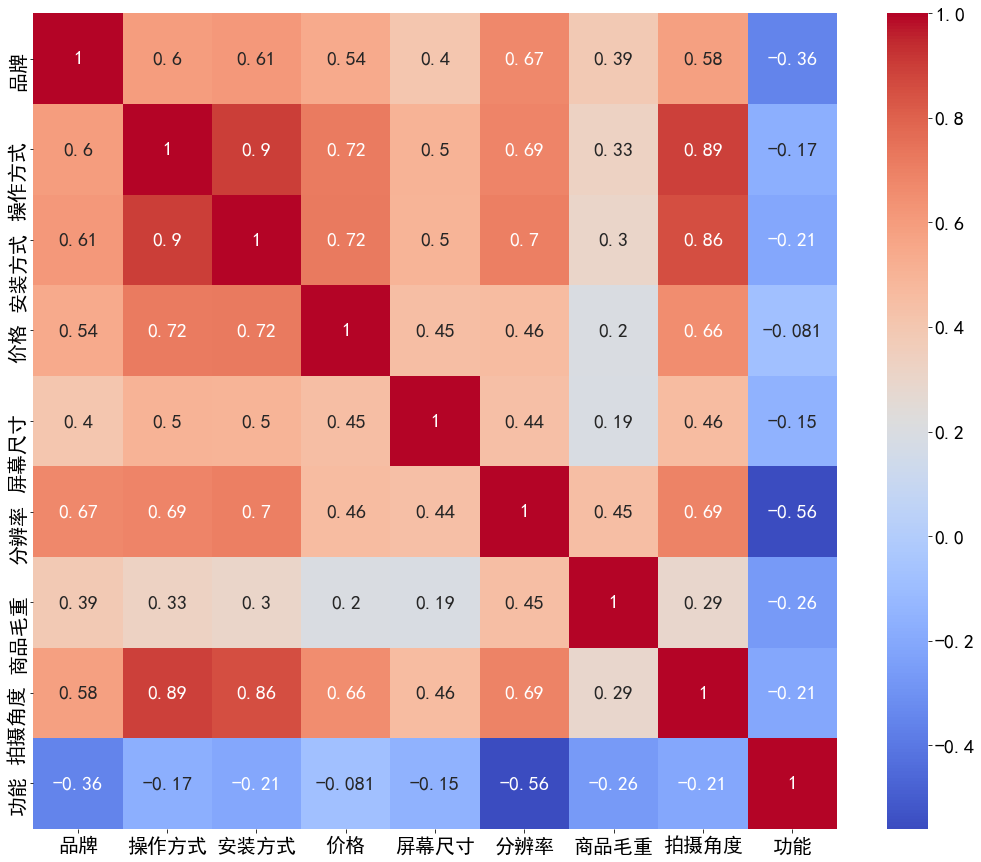

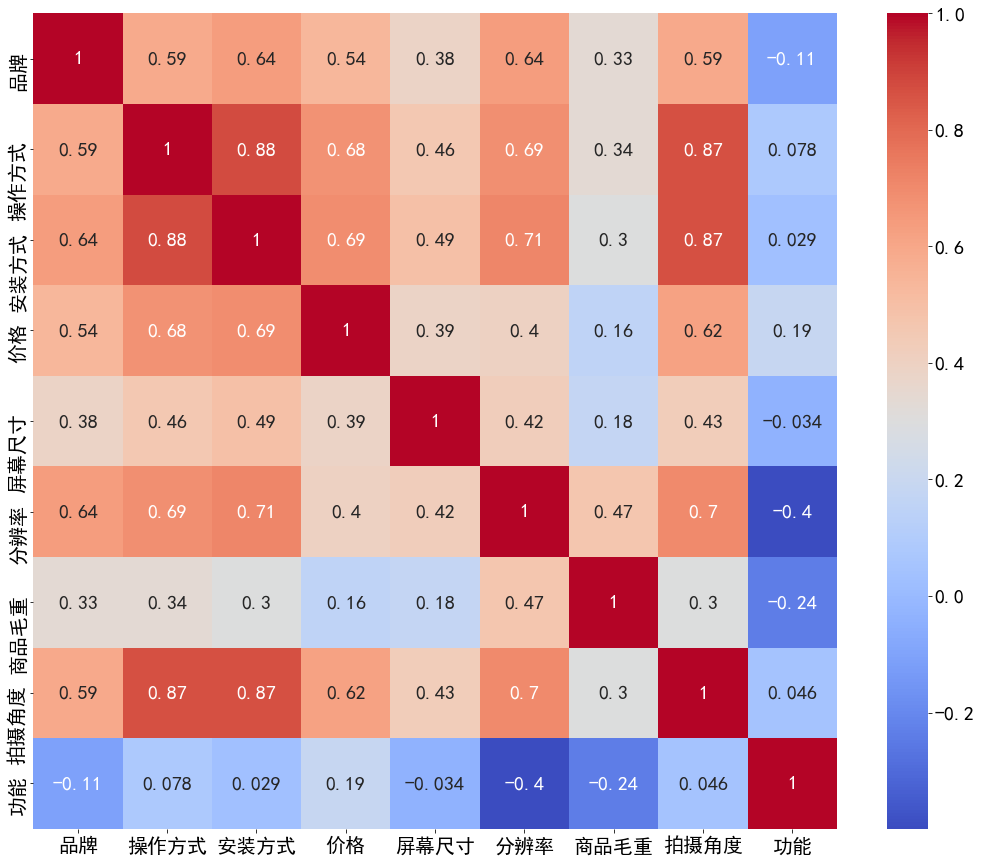

In [ ]:
import seaborn as sns
temp2 = record[['品牌','操作方式','安装方式','价格','屏幕尺寸','分辨率','商品毛重','拍摄角度','功能']].copy()
num_map_keys = ['品牌','操作方式','安装方式','屏幕尺寸','分辨率','拍摄角度','功能']
for key in num_map_keys:
    temp2[key] = pd.factorize(temp2[key])[0]
plt.figure(figsize=(18,15))
sns.heatmap(temp2.corr(method="spearman"),cmap='coolwarm',annot = True)
plt.show()
plt.figure(figsize=(18,15))
sns.heatmap(temp2.corr(method="pearson"),cmap='coolwarm',annot = True)
plt.show()

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules 

from mlxtend.preprocessing import TransactionEncoder
TE = TransactionEncoder()

data = TE.fit_transform(record[['品牌','操作方式','安装方式','分辨率','拍摄角度']].values.tolist())

df_relation_features = pd.DataFrame(data, columns=TE.columns_)

items = apriori(df_relation_features, min_support=0.2, use_colnames=True)
print(items)

     support           itemsets
0   0.389365             ( 吉士野)
1   0.515152            (1080p)
2   0.232133          (170°及以上)
3   0.489423            (专车专用式)
4   0.340194               (按键)
5   0.521441               (未知)
6   0.388794      (专车专用式,  吉士野)
7   0.389365         ( 吉士野, 未知)
8   0.271012        (1080p, 按键)
9   0.489423        (专车专用式, 未知)
10  0.388794  (专车专用式,  吉士野, 未知)


In [ ]:
from mlxtend.frequent_patterns import fpgrowth
items = fpgrowth(df_relation_features, min_support=0.2, use_colnames=True)
print(items)

     support           itemsets
0   0.340194               (按键)
1   0.515152            (1080p)
2   0.232133          (170°及以上)
3   0.521441               (未知)
4   0.489423            (专车专用式)
5   0.389365             ( 吉士野)
6   0.271012        (1080p, 按键)
7   0.489423        (专车专用式, 未知)
8   0.389365         ( 吉士野, 未知)
9   0.388794      (专车专用式,  吉士野)
10  0.388794  (专车专用式,  吉士野, 未知)


In [ ]:
# 发现功能与其他特征关联性很低，考虑到功能属性比较特殊，所以单独分析其内部属性的关联度
TE = TransactionEncoder()
data = TE.fit_transform(ability)

df_ability = pd.DataFrame(data, columns=TE.columns_)

items = apriori(df_ability, min_support=0.2, use_colnames=True)
items

support            itemsets
0   0.207547              (WIFI)
1   0.249857              (倒车影像)
2   0.344197              (停车监控)
3   0.271012              (前后双录)
4   0.815323              (夜视加强)
5   0.216695               (电子狗)
6   0.214980        (停车监控, 倒车影像)
7   0.235563        (倒车影像, 前后双录)
8   0.228130        (停车监控, 前后双录)
9   0.242996        (停车监控, 夜视加强)
10  0.209834        (前后双录, 夜视加强)
11  0.210406  (停车监控, 倒车影像, 前后双录)

In [ ]:
from mlxtend.frequent_patterns import fpgrowth
fpgrowth(df_ability, min_support=0.2, use_colnames=True)

support            itemsets
0   0.815323              (夜视加强)
1   0.344197              (停车监控)
2   0.271012              (前后双录)
3   0.249857              (倒车影像)
4   0.207547              (WIFI)
5   0.216695               (电子狗)
6   0.242996        (停车监控, 夜视加强)
7   0.228130        (停车监控, 前后双录)
8   0.209834        (前后双录, 夜视加强)
9   0.235563        (倒车影像, 前后双录)
10  0.214980        (停车监控, 倒车影像)
11  0.210406  (停车监控, 倒车影像, 前后双录)

In [ ]:
record = pd.read_excel('行车记录仪.xlsx')
# 数据处理
# 去除数据不全的条目

# 价格是不能为空的，如果价格为空则去掉
record = record.dropna(axis = 0,subset = ['价格'])
# 将品牌为空的条目去掉
record = record.dropna(axis = 0,subset = ['品牌'])
# 发现一条数据：便携式移动充电宝 黄色	29.00	移路通（Yilutong）		按键	无屏幕	150°-169°	夜视加强	1296P	通用双镜头	20.0kg
record = record.drop(record[record['商品毛重'] == '20.0kg'].index)

# 缺失值处理
record['操作方式'].fillna('未知', inplace = True)
record['分辨率'].fillna('未知', inplace = True)
record['拍摄角度'].fillna('未知', inplace = True)
record['安装方式'].fillna('其他', inplace = True)
record['商品产地'].fillna('未知', inplace = True)
# lost_price_brand = ''
# record['价格'].fillna(record[record['品牌'] == lost_price_brand]['价格'].mean())
# record['功能'].fillna('', inplace = True)
# 商品产地为空的超过了2/3，并且非空的大部分是“中国大陆”，所以去掉
for index,row in record.iterrows():
    if row['屏幕尺寸'] == '无屏幕':
        record.loc[index,'屏幕尺寸'] = 0.0
    else:
        record.loc[index,'屏幕尺寸'] = float(row['屏幕尺寸'].split("英寸")[0])
    record.loc[index,'商品毛重'] = float(row['商品毛重'].split("g")[0])
    record.loc[index,'评论数'] = int(row['评论数'].split('+')[0])
record['商品毛重'] = record['商品毛重'].astype('float')
# 异常值处理
# 发现一条数据：便携式移动充电宝 黄色	29.00	移路通（Yilutong）		按键	无屏幕	150°-169°	夜视加强	1296P	通用双镜头	20.0kg
record.drop(record[record['商品毛重'] == '20.0kg'].index)
# 商品毛重有几个值特别大
weight_list = list(record['商品毛重'])
weight_list.sort(reverse = True)
record = record.drop(record[record['商品毛重'] >= 100000].index)
record.replace({'480P':480,'720p':720,'1080p': 1080, '1296P': 1296, '1440P': 1440,'2K及以上':2000,'未知':0},inplace=True)
record[['价格','屏幕尺寸','商品毛重','分辨率']]

价格  屏幕尺寸    商品毛重   分辨率
0     279.00   2.7    74.0  1296
1     349.00   3.0   366.0  1080
2     329.00   2.0   400.0  1296
3     199.00   2.7   280.0  1080
5     399.00   7.0  1000.0  1080
...      ...   ...     ...   ...
1794  838.00   0.0   740.0  1080
1795  278.00   7.0   350.0  1080
1796  258.00   2.4  1000.0  1080
1797   39.98   0.0   300.0  2000
1798  128.00   0.0   300.0  1080

[1749 rows x 4 columns]

### 回归分析（讨论行车记录仪价格、尺寸、重量和分辨率等对销售量的影响）

In [ ]:
# 回归分析 将Y变成连续变量
from sklearn.linear_model import LinearRegression
# 构建线性回归模型
model = LinearRegression()
X = np.array(record[['价格','屏幕尺寸','商品毛重','分辨率']]).tolist()
Y = list(record['评论数'])
model.fit(X, Y)
print(pd.DataFrame(model.coef_,index=['价格','屏幕尺寸','商品毛重','分辨率']))

              0
价格    -0.356101
屏幕尺寸  48.956934
商品毛重  -0.091343
分辨率    0.571620


In [ ]:
# 构建逻辑回归模型
model2 = LogisticRegression()
model2.fit(X, Y)
print(pd.DataFrame(model2.coef_,columns=['价格','屏幕尺寸','商品毛重','分辨率']).mean())

价格     -4.246038e-18
屏幕尺寸    4.405359e-19
商品毛重   -7.090178e-18
分辨率    -5.760139e-18
dtype: float64


c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='价格'>

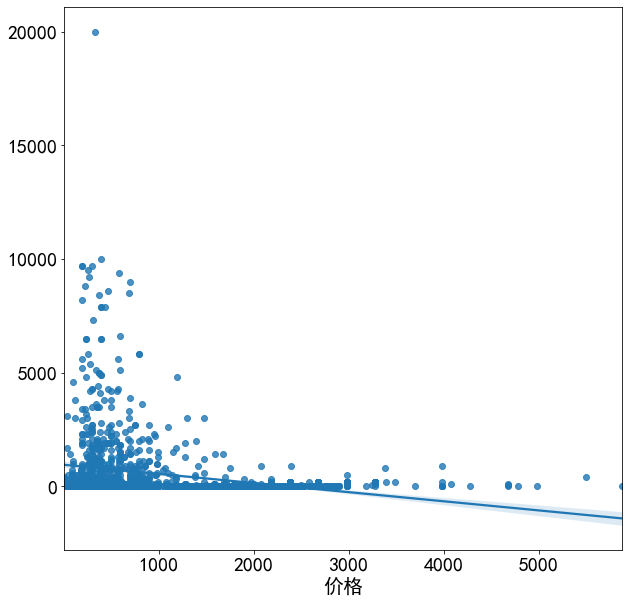

In [ ]:
# 可视化
plt.figure(figsize=(10,10)) 
sns.regplot(record['价格'],Y)

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='屏幕尺寸'>

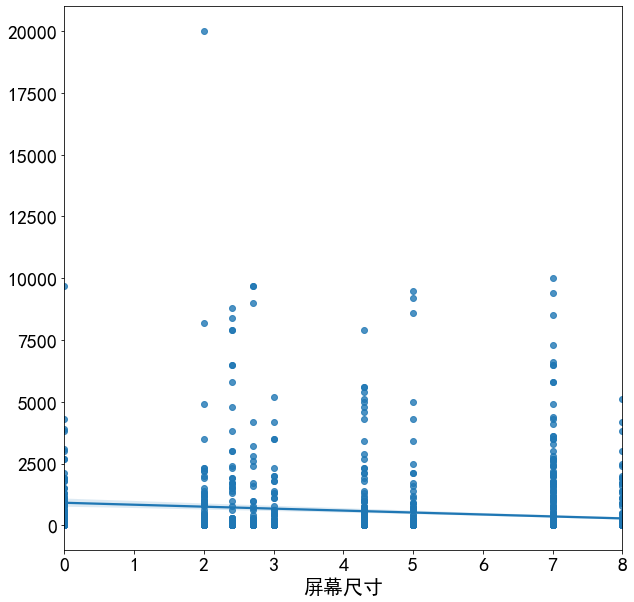

In [ ]:
plt.figure(figsize=(10,10)) 
sns.regplot(record['屏幕尺寸'],Y)

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='商品毛重'>

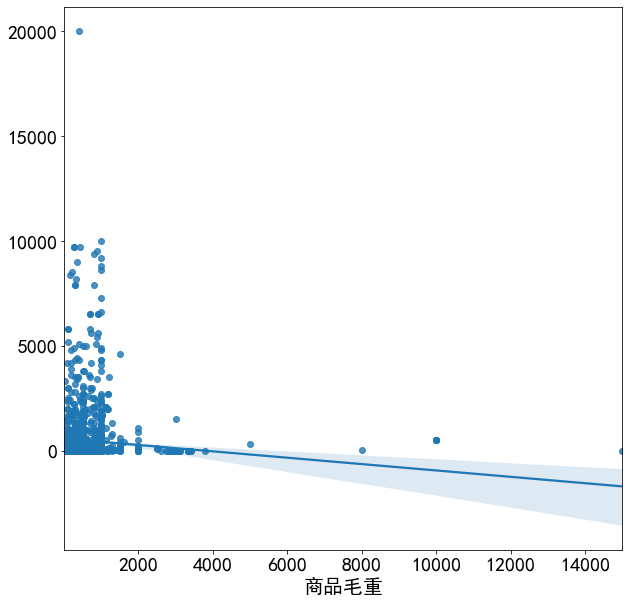

In [ ]:
plt.figure(figsize=(10,10)) 
sns.regplot(record['商品毛重'],Y)

c:\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='分辨率'>

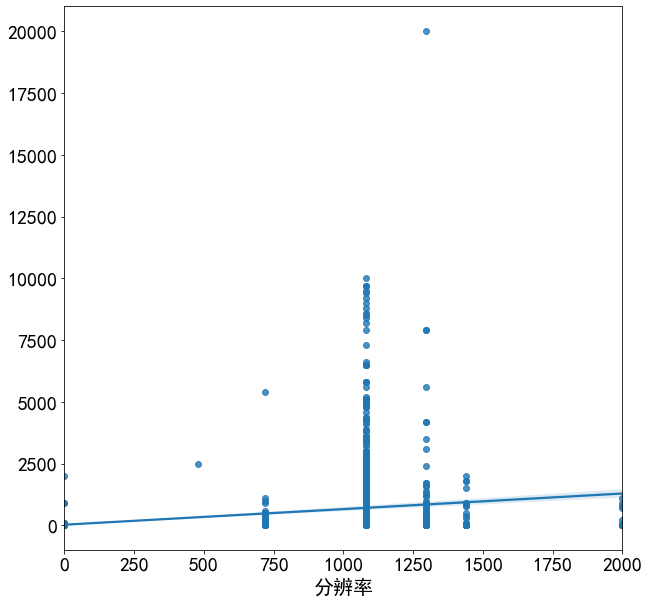

In [ ]:
plt.figure(figsize=(10,10)) 
sns.regplot(record['分辨率'],Y)